## Project Overview

This project demonstrates a full machine learning pipeline using XGBoost regression to forecast revenue based on product-level sales data.

We start with feature engineering, move to initial modeling, examine errors and residuals, apply residual modeling and bias correction, and finish with cross-validation and hyperparameter tuning.

Each section is structured to show real-world practices including diagnostics and business relevance.

**Disclaimer – Experimental Baseline**
> This notebook is an *exploratory sandbox* for the pure XGBoost baseline and successive diagnostic steps (feature expansion, residual modeling, per‑product bias fixes).  
> Results here are **not** the final production forecasts; they are used to (a) surface bias, (b) identify variance suppression, and (c) inform which hybrid path to promote.  
> Extremely low post‑residual errors (near-zero MAE/RMSE) signal potential *overfitting to historical patterns* (especially when residual models reuse in‑sample information). Final model selection therefore relies on a strict 2023 hold‑out evaluation consolidated in `08_hybrid_forecasts.ipynb`.

In [366]:
import pandas as pd
import numpy as np

In [7]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo (raw view)
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/processed/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [9]:
# Load the Product Sales Interpolated dataset

def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)   # pandas handles https URLs

# EXAMPLE
df_raw = load_processed("03_product_sales_interpolated_data.csv")

In [368]:
# Explore dataset
df = df_raw.copy()

In [369]:
df.head()

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
0,2019-01-01,Alpha,146.0,100.151629,Jan,2019,14622.137902,False
1,2019-02-01,Alpha,144.0,120.196688,Feb,2019,17308.323033,False
2,2019-03-01,Alpha,129.0,59.398194,Mar,2019,7662.367024,False
3,2019-04-01,Alpha,136.0,96.559802,Apr,2019,13132.133047,False
4,2019-05-01,Alpha,129.0,109.083326,May,2019,14071.749061,False


In [370]:
df.tail()

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
235,2023-08-01,Delta,116.0,92.135700,Aug,2023,10687.741226,False
236,2023-09-01,Delta,109.0,61.047411,Sep,2023,6654.167833,True
237,2023-10-01,Delta,102.0,79.630812,Oct,2023,8122.342829,False
238,2023-11-01,Delta,104.0,51.787393,Nov,2023,5385.888921,False
239,2023-12-01,Delta,116.0,71.825389,Dec,2023,8331.745099,False


In [371]:
df.sort_values('Date', inplace=True)

In [372]:
df.head()

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
0,2019-01-01,Alpha,146.0,100.151629,Jan,2019,14622.137902,False
60,2019-01-01,Beta,142.0,146.322254,Jan,2019,20777.760060,False
180,2019-01-01,Delta,124.0,65.615260,Jan,2019,8136.292207,False
120,2019-01-01,Gamma,133.0,105.676289,Jan,2019,14054.946477,False
181,2019-02-01,Delta,140.0,52.709599,Feb,2019,7379.343895,False


## 1. Data Preparation & Feature Engineering

In this section, we prepare the dataset by creating new features from date components and product details. We also convert categories and flags into numeric forms that are suitable for model training.

In [374]:
df.tail()

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
58,2023-11-01,Alpha,117.0,108.336877,Nov,2023,12675.414552,False
119,2023-12-01,Beta,131.0,67.088759,Dec,2023,8788.627395,False
59,2023-12-01,Alpha,149.0,78.571209,Dec,2023,11707.110086,False
179,2023-12-01,Gamma,116.0,114.399954,Dec,2023,13270.394702,False
239,2023-12-01,Delta,116.0,71.825389,Dec,2023,8331.745099,False


In [375]:
# Convert 'Product' column to numerical codes for modeling (e.g., Alpha → 0, Beta → 1, etc.)
df['Product_Code'] = df['Product'].astype('category').cat.codes

In [376]:
# Ensure 'Date' column is in datetime format
df['Month_Num'] = pd.to_datetime(df['Date']).dt.month

In [377]:
# # Convert interpolation flag from boolean (True/False) to numeric (1/0) for ML input
df['Interpolated_Flag_Num'] = df['Interpolated_Flag'].astype(int)

In [378]:
df.head()

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag,Product_Code,Month_Num,Interpolated_Flag_Num
0,2019-01-01,Alpha,146.0,100.151629,Jan,2019,14622.137902,False,0,1,0
60,2019-01-01,Beta,142.0,146.322254,Jan,2019,20777.760060,False,1,1,0
180,2019-01-01,Delta,124.0,65.615260,Jan,2019,8136.292207,False,2,1,0
120,2019-01-01,Gamma,133.0,105.676289,Jan,2019,14054.946477,False,3,1,0
181,2019-02-01,Delta,140.0,52.709599,Feb,2019,7379.343895,False,2,2,0


In [379]:
df_codes = df[['Product', 'Product_Code']].drop_duplicates()
df_codes

,Product,Product_Code
0,Alpha,0
60,Beta,1
180,Delta,2
120,Gamma,3


In [380]:
# # Define feature columns and target variable for the initial model
features = ['Month_Num', 'Year', 'Product_Code', 'Units_Sold', 'Unit_Price','Interpolated_Flag_Num']
target = ['Revenue']

In [381]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [382]:
# Prepare input matrix X and target vector y
X = df[features]
y = df[target]

✅ The initial train-test split was not shuffled, which preserved natural time or grouping order

## 2. Initial Modeling with XGBoost

We train an initial XGBoost model to predict revenue using basic features. Evaluation metrics like MAE and RMSE help assess model quality.

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [386]:
# Initialize XGBoost regressor with basic configuration
# n_estimators = number of trees, learning_rate = shrinkage rate, max_depth = tree depth
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train model on training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [387]:
# Predict revenue values on test data
y_pred = model.predict(X_test)

# Evaluate prediction performance using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# Output main error metrics (lower = better)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 268.90
RMSE: 319.61


In [388]:
# Calculate R² (coefficient of determination) on train and test sets
# R² close to 1.0 indicates good fit
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)
print(f"Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}")

Train R2: 0.9989, Test R2: 0.9931


✅ Results looked good at a global level. But product-specific bias and uneven performance were correctly suspected

In [390]:
df['Revenue'].describe()

count      240.000000
mean     11817.692653
std       3838.159217
min       4633.483394
25%       8733.032319
50%      11675.506735
75%      14643.557118
max      22043.607778
Name: Revenue, dtype: float64

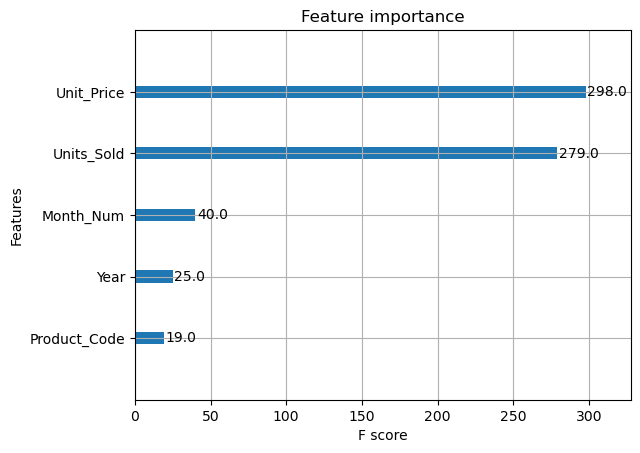

In [391]:
# Plot feature importance as determined by the trained XGBoost model
# Helps interpret which features influenced predictions most
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

### 🧾 Preparing Test Data Summary

Create a new `test_data` table that includes:

- Input features (`X_test`)
- Actual and predicted revenue
- Corresponding `Date` and `Product` metadata

This makes it easy to evaluate model performance and visualize results.

In [393]:
# Create a copy of test features and attach actual vs. predicted revenue
test_data = X_test.copy()
test_data['Actual'] = y_test.values
test_data['Predicted'] = y_pred

In [394]:
# Add contextual info for visualization: original Date and Product columns
# Useful for plotting time series per product
test_data['Date'] = df.loc[test_data.index, 'Date']
test_data['Product'] = df.loc[test_data.index, 'Product']

In [395]:
# Get list of unique products for visualization
products = test_data['Product'].unique()
num_products = len(products)

### 📈 Visualizing Predictions per Product

Line plots showing `Actual` vs `Predicted` revenue over time for each product.

This helps:
- Identify where predictions were close or off
- Detect temporal patterns in errors

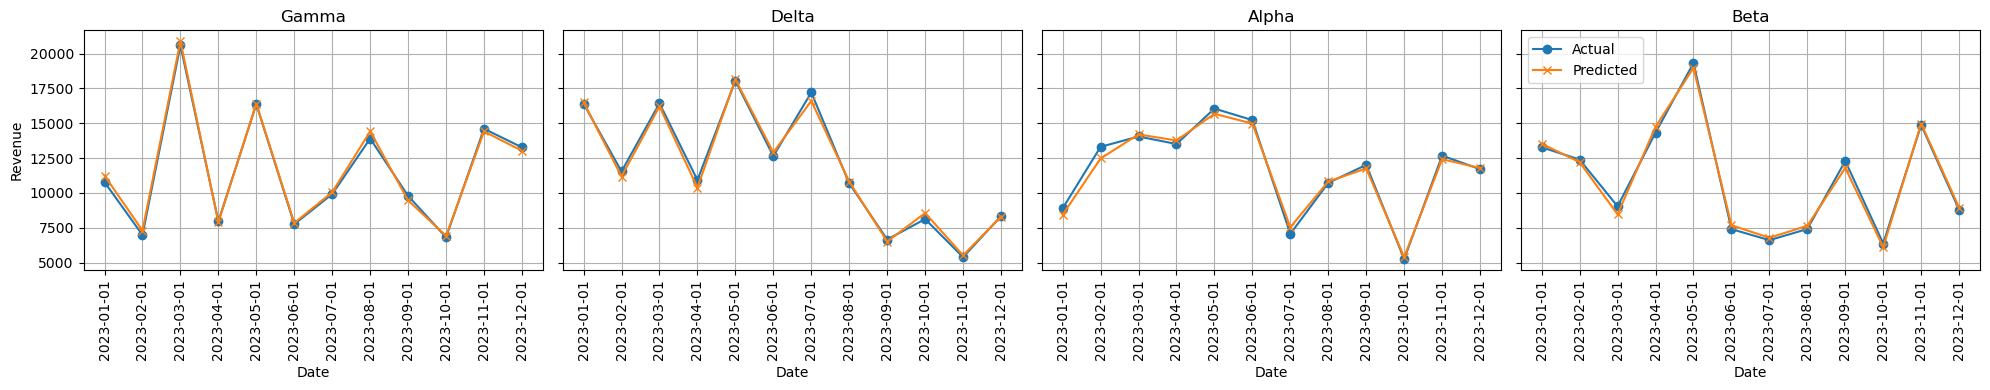

In [397]:
# Plot Actual vs. Predicted revenue per product over time
# This helps spot where predictions match or miss over time
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

for i, product in enumerate(products):
    ax = axes[i]
    product_df = test_data[test_data['Product'] == product]

    ax.plot(product_df['Date'], product_df['Actual'], label='Actual', marker='o')
    ax.plot(product_df['Date'], product_df['Predicted'], label='Predicted', marker='x')
    ax.set_title(f"{product}")
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)
    
    if i == 0:
        ax.set_ylabel("Revenue")
    if i == num_products - 1:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

### 📉 Row-Level Error Metrics

Add several error metrics to each row for deeper evaluation:

- **Absolute Error**
- **Squared Error**
- **Percentage Error**
- **Symmetric MAPE (SMAPE)**

These allow for robust, product-level aggregation and fairness checks.


In [399]:
# Calculate raw error and absolute error for each row
test_data['Error'] = test_data['Actual'] - test_data['Predicted']
test_data['Absolute_Error'] = np.abs(test_data['Error'])

In [400]:
# Compute squared error and RMSE (Root Mean Squared Error)
# RMSE penalizes large deviations more heavily
test_data['Squared_Error'] = test_data['Error'] ** 2
rmse = np.sqrt(test_data['Squared_Error'].mean())

In [401]:
# Calculate percentage error and MAPE (Mean Absolute Percentage Error)
# MAPE expresses average error as a % of actual value
test_data['Percentage_Error'] = test_data['Error'] / test_data['Actual'] * 100
mape = np.mean(np.abs(test_data['Percentage_Error']))

In [402]:
# Compute SMAPE (Symmetric Mean Absolute Percentage Error)
# More stable than MAPE when actual values are close to zero
test_data['SMAPE'] = 100 * np.abs(test_data['Actual'] - test_data['Predicted']) / ((np.abs(test_data['Actual']) + np.abs(test_data['Predicted'])) / 2)
smape = test_data['SMAPE'].mean()

### 📊 Product-Level Error Summary

Group errors by product and compute averages to:

- Compare product accuracy
- Identify segments needing model improvement

In [404]:
# Aggregate error metrics per product for performance comparison
summary = test_data.groupby('Product').agg({
    'Absolute_Error': 'mean',
    'Squared_Error' : 'mean',
    'Percentage_Error': 'mean',
    'SMAPE': 'mean'
})

In [405]:
# Display summary metrics per product
# Helps compare prediction quality across different product lines
summary

,Absolute_Error,Squared_Error,Percentage_Error,SMAPE
Product,,,,
Alpha,301.042955,131285.552219,0.460947,2.789490
Beta,289.370078,103338.361780,0.082666,2.894645
Delta,254.921919,98267.590167,0.279158,2.311353
Gamma,230.274254,75717.073042,-0.906079,2.093594


## 3. Model Diagnostics & Error Analysis

We explore the residuals (errors between actual and predicted values) through visualizations and statistics. The goal is to uncover bias or patterns the model missed.

In [407]:
product_df.head()

,Month_Num,Year,Product_Code,Units_Sold,Unit_Price,Interpolated_Flag_Num,Actual,Predicted,Date,Product
108,1,2023,1,133.0,99.844220,0,13279.281246,13534.021484,2023-01-01,Beta
109,2,2023,1,114.0,108.684112,0,12389.988745,12207.256836,2023-02-01,Beta
110,3,2023,1,144.0,62.758030,0,9037.156360,8457.432617,2023-03-01,Beta
111,4,2023,1,125.0,114.591724,0,14323.965517,14747.715820,2023-04-01,Beta
112,5,2023,1,130.0,148.651525,0,19324.698234,18981.390625,2023-05-01,Beta


In [408]:
# Compute residuals (error = Actual - Predicted)
# Used to detect systemic under/overestimation
test_data['Residual'] = test_data['Actual'] - test_data['Predicted']

### 📉 Residuals Over Time per Product

Plotting residuals helps detect:

- Systematic over/underprediction
- Seasonal or product-specific bias

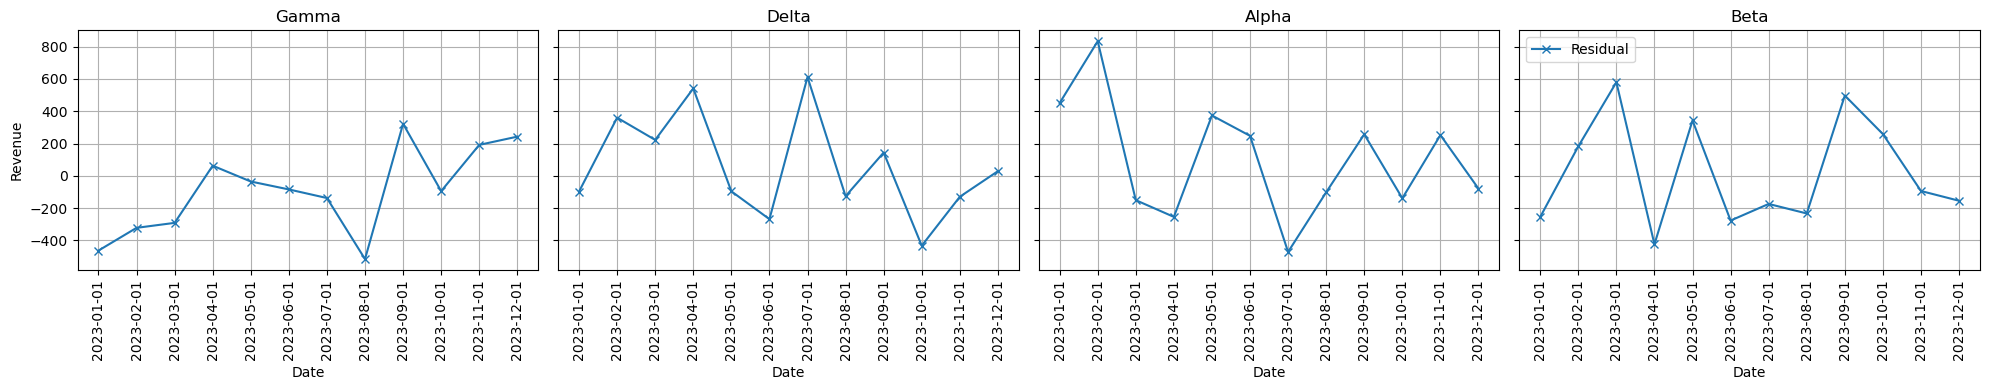

In [410]:
# Plot residuals over time for each product
# Helps reveal temporal patterns or biases in prediction
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

for i, product in enumerate(products):
    ax = axes[i]
    product_df = test_data[test_data['Product'] == product]

    ax.plot(product_df['Date'], product_df['Residual'], label='Residual', marker='x')
    ax.set_title(f"{product}")
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)
    
    if i == 0:
        ax.set_ylabel("Revenue")
    if i == num_products - 1:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [411]:
# Show summary statistics (mean, std, min, max, etc.) of residuals per product
# Helps compare error magnitude and bias across product lines
test_data.groupby('Product')['Residual'].describe()

,count,mean,std,min,25%,50%,75%,max
Product,,,,,,,,
Alpha,12.0,101.717759,363.226525,-471.333222,-141.893597,84.401908,286.412525,833.926789
Beta,12.0,20.942020,335.043759,-423.750304,-238.479241,-124.071881,279.745110,579.723743
Delta,12.0,63.349510,320.660279,-432.644476,-126.914965,-33.437477,257.039094,612.065508
Gamma,12.0,-93.565221,270.277882,-515.554642,-298.978966,-89.361361,95.161232,322.590771


In [412]:
# Plot overall distribution of residuals
# Ideally centered around 0; spread shows model accuracy
import seaborn as sns
sns.histplot(test_data['Residual'], kde=True)
plt.title("Distribution of Residuals")

Text(0.5, 1.0, 'Distribution of Residuals')

#### 4. Residual Normality & Distribution Checks

We apply a global bias correction to address systematic under- or over-predictions. This step improves the accuracy of our model’s forecasts.

📌 **Why this matters**: Residuals often contain systematic bias. Correcting for global bias helps center predictions more accurately — critical for business decisions like forecasting demand or revenue.

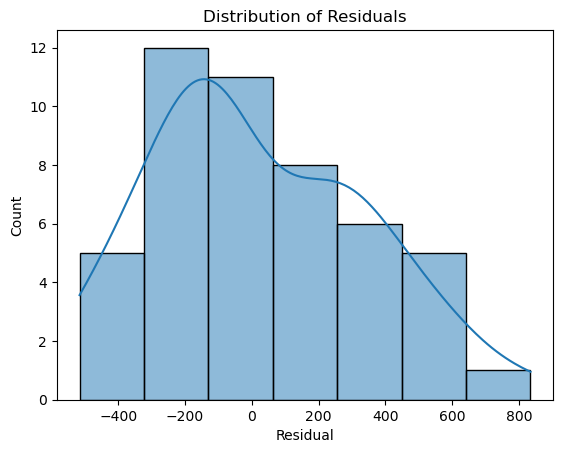

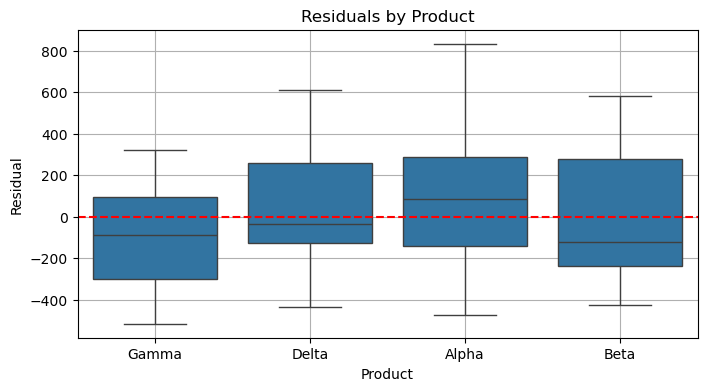

In [414]:
# Boxplot to compare residuals across products
# Useful to detect systematic over/under-prediction by product
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.boxplot(x='Product', y='Residual', data=test_data)
plt.title("Residuals by Product")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

In [415]:
# Compute global bias — average residual across all predictions
# Positive bias → model underpredicts on average
bias = test_data['Residual'].mean()
print(f"Global Bias Correction: {bias:.2f}")

# Apply global bias correction to predictions
# Adjusts all predictions to reduce overall under/overestimation
test_data['Corrected_Predicted'] = test_data['Predicted'] - bias

Global Bias Correction: 23.11


## 4. Residual Normality & Distribution Checks

We apply a global bias correction to address systematic under- or over-predictions. This step improves the accuracy of our model’s forecasts.

📌 **Why this matters**: Residuals often contain systematic bias. Correcting for global bias helps center predictions more accurately — critical for business decisions like forecasting demand or revenue.

### ✅ Bias-Corrected Model Evaluation

After applying a global bias correction to the predictions, we reevaluated model performance:

- **MAE** (Mean Absolute Error): Measures average prediction error size.
- **RMSE** (Root Mean Squared Error): Penalizes larger errors more strongly.

These metrics help verify whether our correction step improved model reliability.

In [418]:
# Evaluate performance after applying bias correction
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

corrected_mae = mean_absolute_error(test_data['Actual'], test_data['Corrected_Predicted'])
corrected_rmse = root_mean_squared_error(test_data['Actual'], test_data['Corrected_Predicted'])
print(f"Corrected MAE: {corrected_mae:.2f}, Corrected RMSE: {corrected_rmse:.2f}")

Corrected MAE: 266.01, Corrected RMSE: 322.11


In [419]:
# (Re-)define products for visualization
products = test_data['Product'].unique()
num_products = len(products)

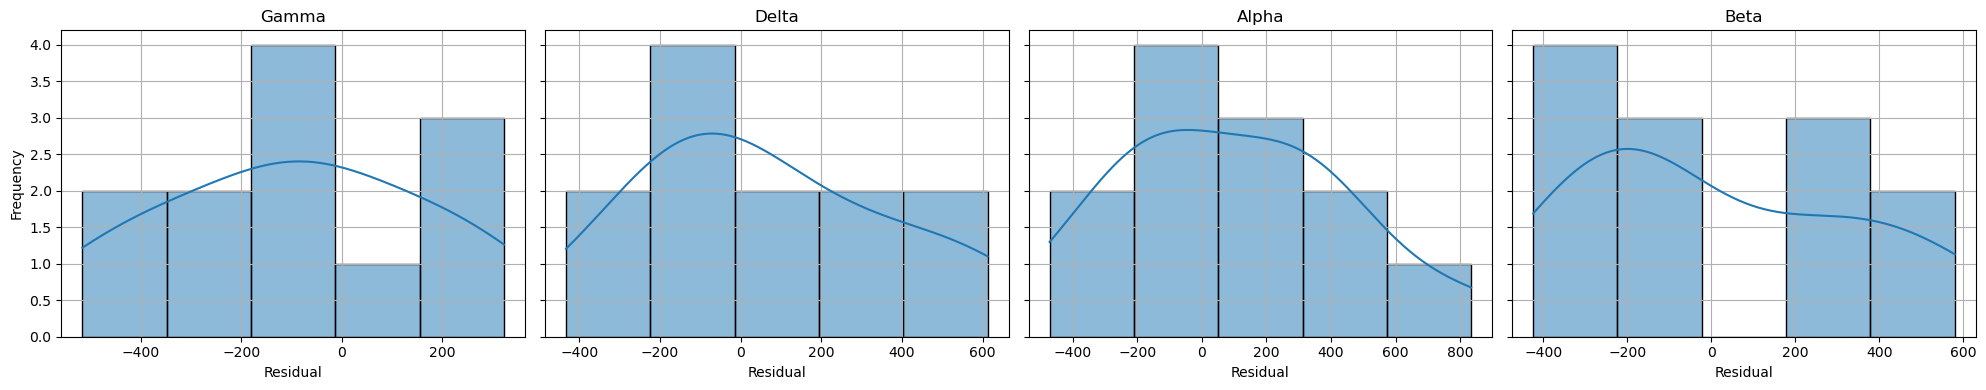

In [420]:
# Plot per-product distribution of residuals (histograms)
# Helps visualize spread and shape of residuals per product
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

# Plot each product’s residuals
for i, product in enumerate(products):
    ax = axes[i]
    product_df = test_data[test_data['Product'] == product]

    sns.histplot(product_df['Residual'], kde=True, ax=ax)
    ax.set_title(f"{product}")
    ax.set_xlabel("Residual")
    ax.grid(True)

    if i == 0:
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### 📈 Skewness Analysis

We calculate the **skewness** of residuals per product to assess asymmetry:

- **Positive skew** → long tail to the right (overpredictions)
- **Negative skew** → long tail to the left (underpredictions)
- **Zero skew** → balanced errors, close to normal distribution

This helps assess the fairness and stability of predictions by product.

In [422]:
# Check skewness of residuals per product
# Skew indicates asymmetry → could hint at product-specific bias
test_data.groupby('Product')['Residual'].skew()

Product
Alpha    0.428086
Beta     0.486995
Delta    0.412063
Gamma   -0.043255
Name: Residual, dtype: float64

### 📊 Residual Distribution (Histogram + KDE)

Visualize how residuals are distributed for each product. 
- The KDE (curve) helps identify skewness or multi-modality
- Most products should ideally show residuals centered around zero

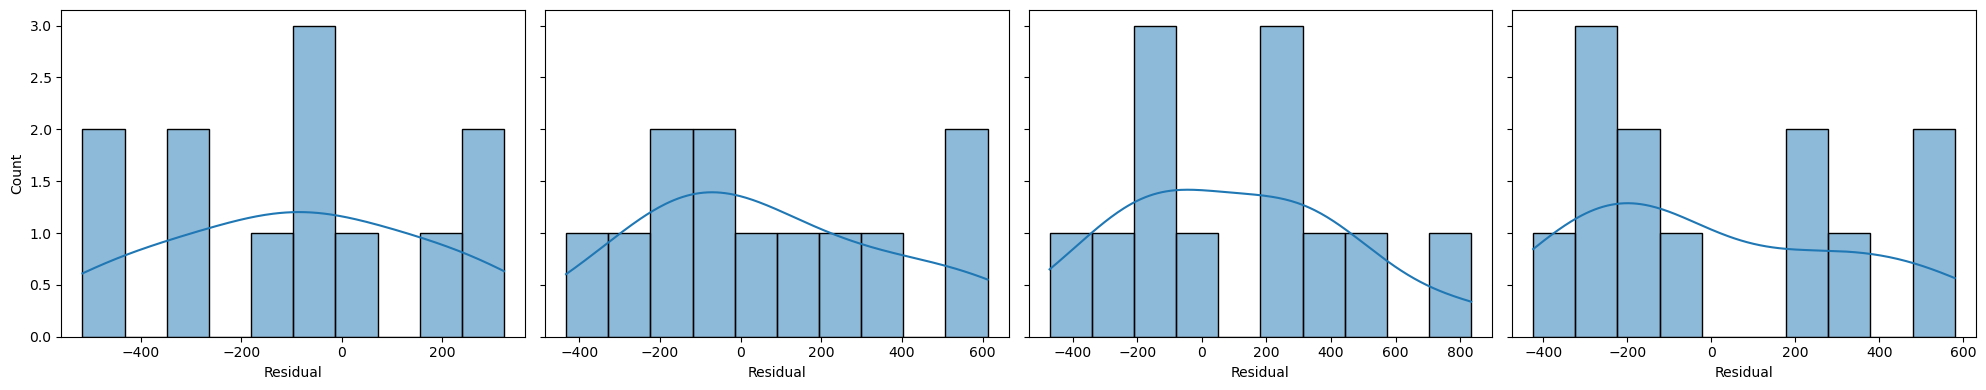

In [424]:
# Plot histogram + KDE of residuals for each product
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

for i, product in enumerate(products):
    product_df = test_data[test_data['Product'] == product]
    sns.histplot(data=product_df, x='Residual', kde=True, ax=axes[i], bins=10)
    
    ax.set_title(f"{product}")
    ax.set_xlabel("Residual")
    ax.grid(True)

    if i == 0:
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show();

In [425]:
# Calculate global bias (mean residual across all predictions)
global_bias = test_data['Residual'].mean()

# Create a new column with residuals corrected for global bias
test_data['Residual_Bias_Corrected'] = test_data['Residual'] - global_bias

In [426]:
global_bias

23.11101710102552

### ⚖️ Global Bias Correction and Normality Diagnostics

- Calculate average residual (global bias) and correct all predictions accordingly.
- Apply **Q-Q plots** to assess how closely residuals follow a normal distribution — useful for checking assumptions before modeling residuals.

This step helps:
- Reduce systematic prediction error (bias)
- Evaluate model assumptions about residual behavior

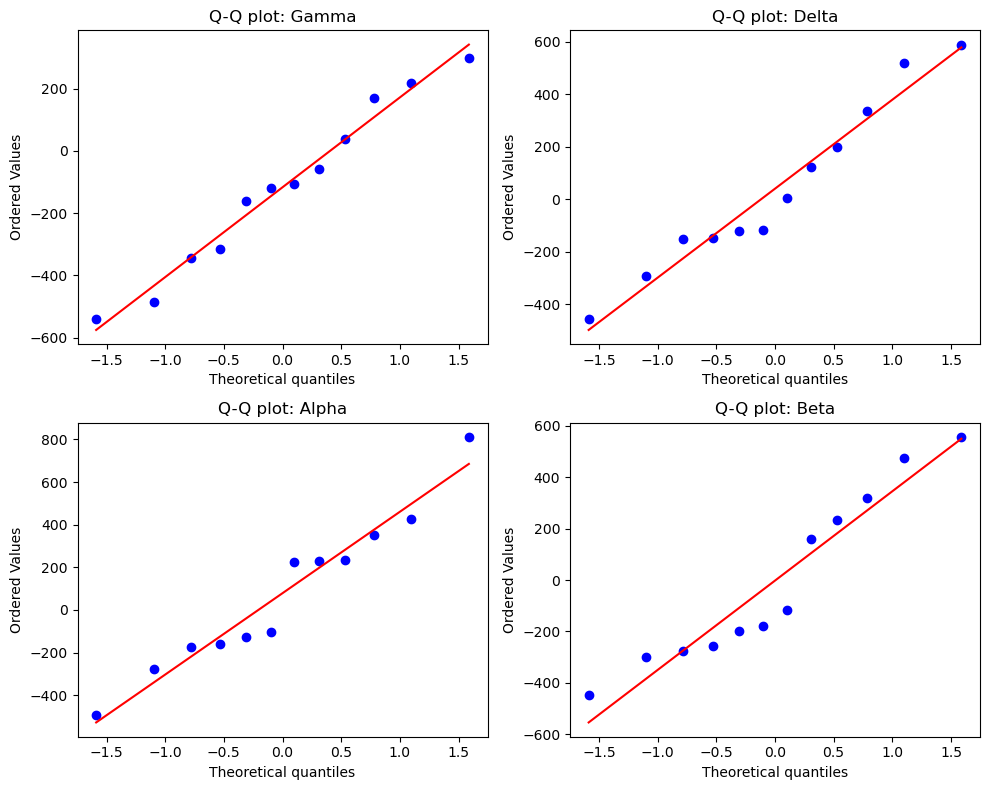

In [428]:
# Q-Q plots to assess normality visually
import scipy.stats as stats

products = test_data['Product'].unique()

# Plot Q-Q plots per product for corrected residuals
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, product in enumerate(products):
    stats.probplot(
        test_data[test_data['Product'] == product]['Residual_Bias_Corrected'],
        dist="norm", plot=axes[i]
    )
    axes[i].set_title(f'Q-Q plot: {product}')

plt.tight_layout()
plt.show()


In [429]:
#  One-Hot Encode the 'Product' column
df = pd.get_dummies(df, columns=['Product'], drop_first=True)

In [430]:
df

,Date,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag,Product_Code,Month_Num,Interpolated_Flag_Num,Product_Beta,Product_Delta,Product_Gamma
0,2019-01-01,146.0,100.151629,Jan,2019,14622.137902,False,0,1,0,False,False,False
60,2019-01-01,142.0,146.322254,Jan,2019,20777.760060,False,1,1,0,True,False,False
180,2019-01-01,124.0,65.615260,Jan,2019,8136.292207,False,2,1,0,False,True,False
120,2019-01-01,133.0,105.676289,Jan,2019,14054.946477,False,3,1,0,False,False,True
181,2019-02-01,140.0,52.709599,Feb,2019,7379.343895,False,2,2,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2023-11-01,117.0,108.336877,Nov,2023,12675.414552,False,0,11,0,False,False,False
119,2023-12-01,131.0,67.088759,Dec,2023,8788.627395,False,1,12,0,True,False,False
59,2023-12-01,149.0,78.571209,Dec,2023,11707.110086,False,0,12,0,False,False,False
179,2023-12-01,116.0,114.399954,Dec,2023,13270.394702,False,3,12,0,False,False,True


❗Add new engineered features

In [432]:
# Price interactions
df['Price_x_Beta']  = df['Unit_Price'] * df['Product_Beta']
df['Price_x_Gamma'] = df['Unit_Price'] * df['Product_Gamma']
df['Price_x_Delta'] = df['Unit_Price'] * df['Product_Delta']

In [433]:
# Units Sold interactions
df['Sold_x_Beta']  = df['Units_Sold'] * df['Product_Beta']
df['Sold_x_Gamma'] = df['Units_Sold'] * df['Product_Gamma']
df['Sold_x_Delta'] = df['Units_Sold'] * df['Product_Delta']

In [434]:
# Ensure your date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [435]:
# Add basic time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday           # 0 = Monday, 6 = Sunday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear

In [436]:
# Time-based interactions for sales behavior changes with month differently per product
df['Month_x_Beta'] = df['Month'] * df['Product_Beta']
df['Month_x_Gamma'] = df['Month'] * df['Product_Gamma']
df['Month_x_Delta'] = df['Month'] * df['Product_Delta']

In [437]:
df.head()

,Date,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag,Product_Code,Month_Num,Interpolated_Flag_Num,...,Sold_x_Gamma,Sold_x_Delta,Day,Weekday,IsWeekend,Quarter,DayOfYear,Month_x_Beta,Month_x_Gamma,Month_x_Delta
0,2019-01-01,146.0,100.151629,1,2019,14622.137902,False,0,1,0,...,0.0,0.0,1,1,0,1,1,0,0,0
60,2019-01-01,142.0,146.322254,1,2019,20777.760060,False,1,1,0,...,0.0,0.0,1,1,0,1,1,1,0,0
180,2019-01-01,124.0,65.615260,1,2019,8136.292207,False,2,1,0,...,0.0,124.0,1,1,0,1,1,0,0,1
120,2019-01-01,133.0,105.676289,1,2019,14054.946477,False,3,1,0,...,133.0,0.0,1,1,0,1,1,0,1,0
181,2019-02-01,140.0,52.709599,2,2019,7379.343895,False,2,2,0,...,0.0,140.0,1,4,0,1,32,0,0,2


In [438]:
df.columns

Index(['Date', 'Units_Sold', 'Unit_Price', 'Month', 'Year', 'Revenue',
       'Interpolated_Flag', 'Product_Code', 'Month_Num',
       'Interpolated_Flag_Num', 'Product_Beta', 'Product_Delta',
       'Product_Gamma', 'Price_x_Beta', 'Price_x_Gamma', 'Price_x_Delta',
       'Sold_x_Beta', 'Sold_x_Gamma', 'Sold_x_Delta', 'Day', 'Weekday',
       'IsWeekend', 'Quarter', 'DayOfYear', 'Month_x_Beta', 'Month_x_Gamma',
       'Month_x_Delta'],
      dtype='object')

In [439]:
#  Define Features and Target
drop_cols = [
    'Date', 'Revenue', 'Product_Code', 'Interpolated_Flag', 'Month_Num'  # optional if duplicate
]

features = [col for col in df.columns if col not in drop_cols]

X = df[features]
y = df['Revenue']

In [440]:
print(X.isnull().sum().sort_values(ascending=False).head())

Units_Sold       0
Unit_Price       0
Month_x_Gamma    0
Month_x_Beta     0
DayOfYear        0
dtype: int64


In [441]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [442]:
# Train XGBoost
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [443]:
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 439.2650224028778
RMSE: 629.2542068108272
R²: 0.9713973252840507


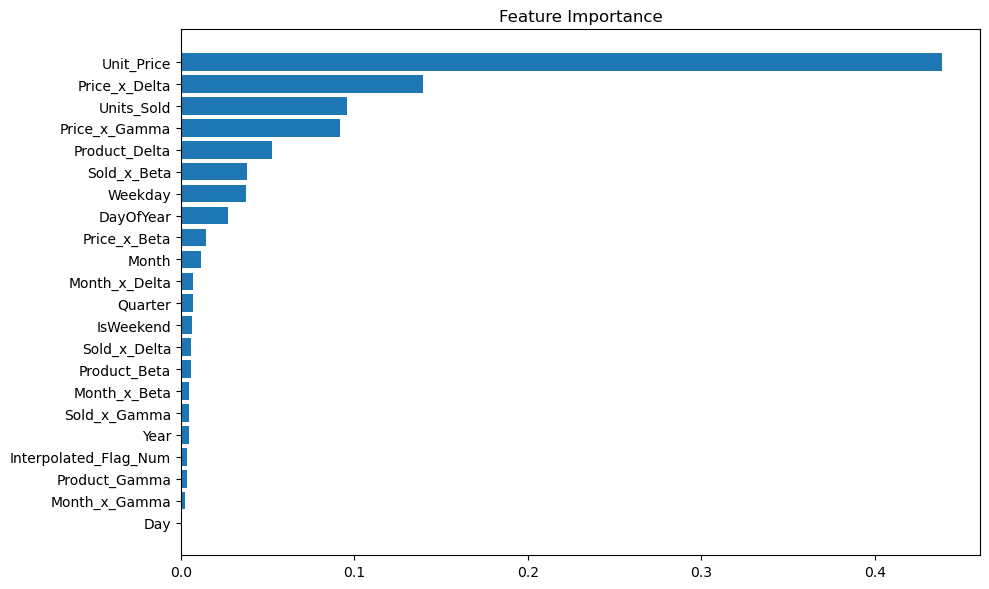

In [444]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

plt.barh(
    [features[i] for i in sorted_idx],
    importance[sorted_idx]
)
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [445]:
xgb.plot_importance(model, max_num_features=10);

In [446]:
# Saving base model for forecasting
xgb_model_base = model 
import joblib
joblib.dump(xgb_model_base, r'C:\Users\eugin\OneDrive\Документы\Traning\POWER_BI\MF_Training\PROJECTS'
                                    r'\Mock_Sales\Project_2_2023_Mock_Set\xgb_model_base.pkl')

['C:\\Users\\eugin\\OneDrive\\Документы\\Traning\\POWER_BI\\MF_Training\\PROJECTS\\Mock_Sales\\Project_2_2023_Mock_Set\\xgb_model_base.pkl']

In [447]:
# Create DataFrame for analysis
test_data = X_test.copy()
test_data['Actual'] = y_test.values
test_data['Predicted'] = y_pred

## 5. Model Diagnostics & Error Analysis

We explore the residuals (errors between actual and predicted values) through visualizations and statistics. The goal is to uncover bias or patterns the model missed.

In [449]:
test_data.head()

,Units_Sold,Unit_Price,Month,Year,Interpolated_Flag_Num,Product_Beta,Product_Delta,Product_Gamma,Price_x_Beta,Price_x_Gamma,...,Day,Weekday,IsWeekend,Quarter,DayOfYear,Month_x_Beta,Month_x_Gamma,Month_x_Delta,Actual,Predicted
66,102.0,85.335223,7,2019,0,True,False,False,85.335223,0.0,...,1,0,0,3,182,7,0,0,8704.192726,8974.563477
1,144.0,120.196688,2,2019,0,False,False,False,0.000000,0.0,...,1,4,0,1,32,0,0,0,17308.323033,16268.897461
203,117.0,101.891771,12,2020,0,False,True,False,0.000000,0.0,...,1,1,0,4,336,0,0,12,11921.337152,11626.199219
27,129.0,95.825289,4,2021,0,False,False,False,0.000000,0.0,...,1,3,0,2,91,0,0,0,12361.462287,12166.569336
206,131.0,85.567272,3,2021,0,False,True,False,0.000000,0.0,...,1,0,0,1,60,0,0,3,11209.312586,11286.551758


In [450]:
test_data['Residual'] = test_data['Actual'] - test_data['Predicted']

In [451]:
# Reverse-engineer Product from one-hot columns
def get_product_label(row):
    if row['Product_Beta'] == 1:
        return 'Beta'
    elif row['Product_Gamma'] == 1:
        return 'Gamma'
    elif row['Product_Delta'] == 1:
        return 'Delta'
    else:
        return 'Alpha'  # Alpha is the baseline (drop_first=True)

In [452]:
# Bring back useful info from the original df
test_data['Product'] = test_data.apply(get_product_label, axis=1)

test_data['Date'] = df.loc[test_data.index, 'Date']

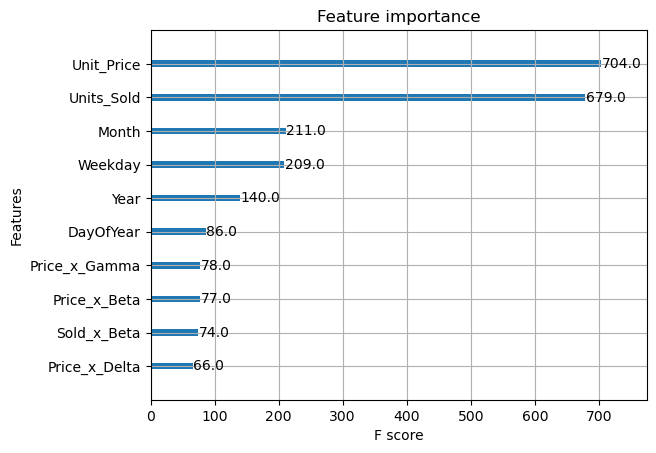

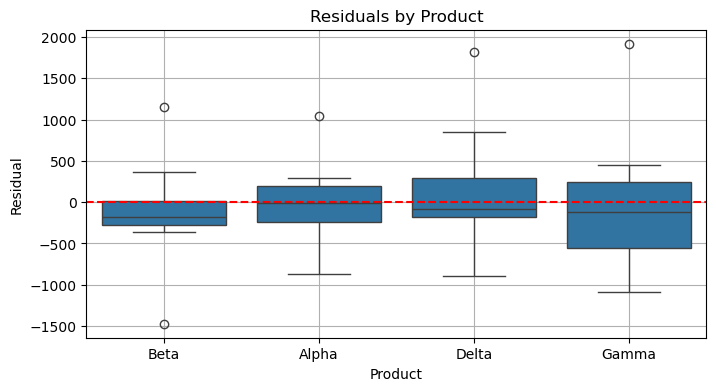

In [453]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Product', y='Residual', data=test_data)
plt.title("Residuals by Product")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

In [454]:
# Get the unique products
products = test_data['Product'].unique()
num_products = len(products)

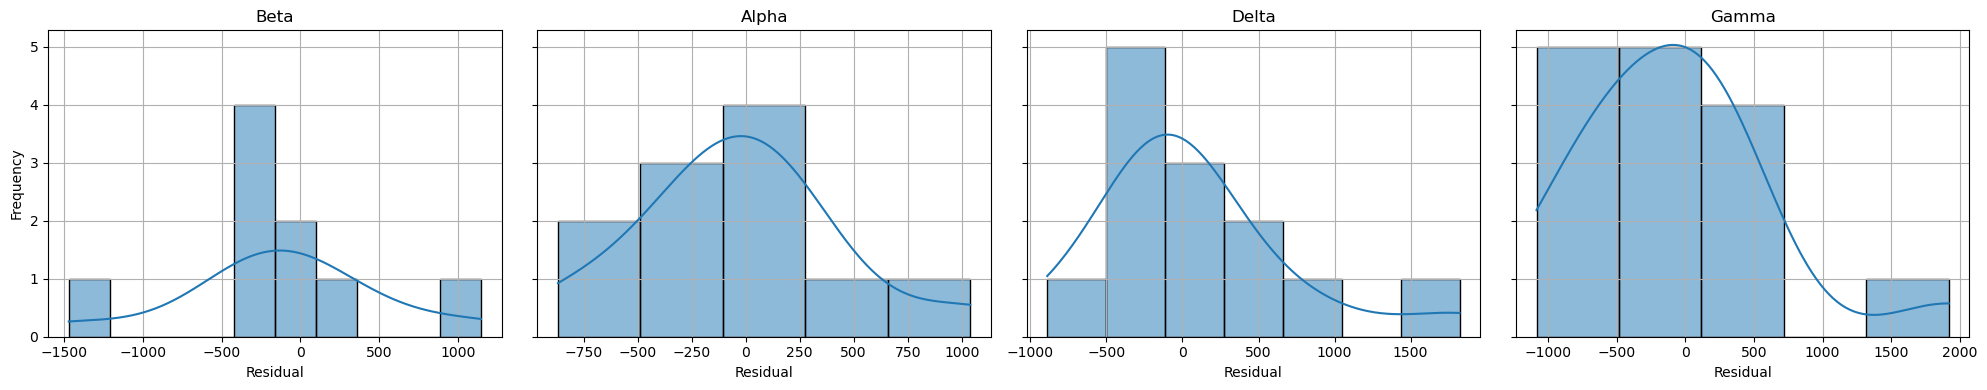

In [455]:
# Create subplots
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

# Plot each product’s residuals
for i, product in enumerate(products):
    ax = axes[i]
    product_df = test_data[test_data['Product'] == product]

    sns.histplot(product_df['Residual'], kde=True, ax=ax)
    ax.set_title(f"{product}")
    ax.set_xlabel("Residual")
    ax.grid(True)

    if i == 0:
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [456]:
global_bias = test_data['Residual'].mean()
test_data['Residual_Bias_Corrected'] = test_data['Residual'] - global_bias
global_bias

-25.061296433515224

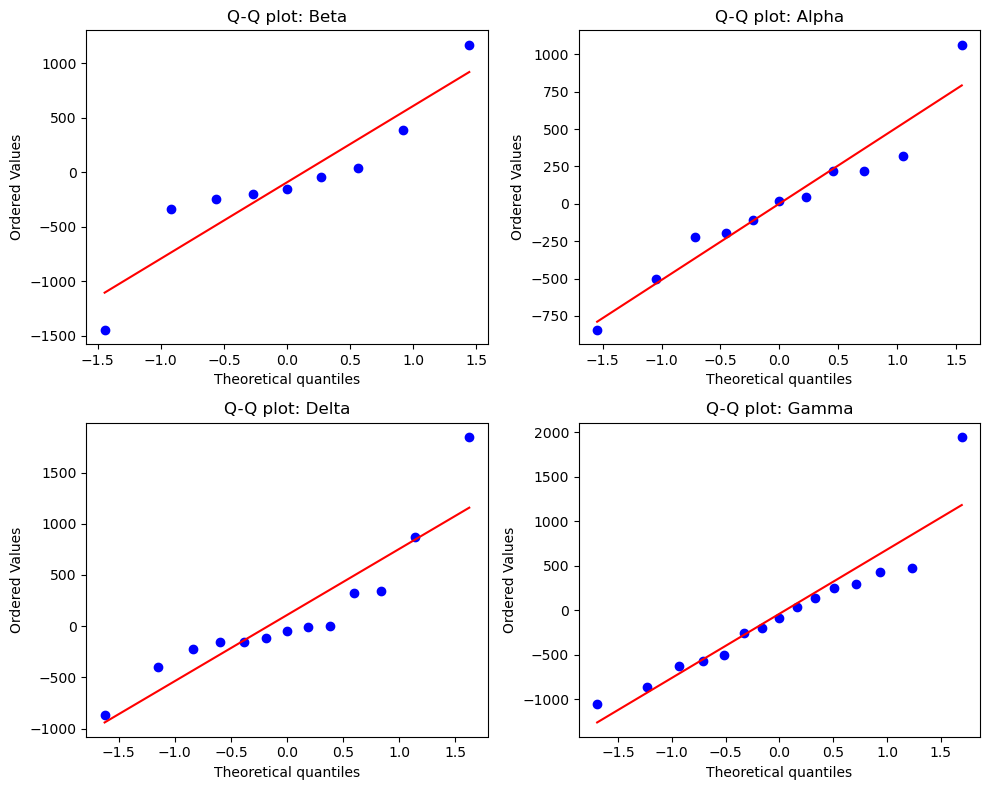

In [457]:
# Q-Q plots to assess normality visually
import scipy.stats as stats

products = test_data['Product'].unique()

# Plot Q-Q plots per product for corrected residuals
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, product in enumerate(products):
    stats.probplot(
        test_data[test_data['Product'] == product]['Residual_Bias_Corrected'],
        dist="norm", plot=axes[i]
    )
    axes[i].set_title(f'Q-Q plot: {product}')

plt.tight_layout()
plt.show()


In [458]:
print(test_data.groupby('Product')['Residual'].skew())

Product
Alpha    0.525022
Beta    -0.185770
Delta    1.553853
Gamma    1.330501
Name: Residual, dtype: float64


✅ 1. Model:
Performs very well for Beta and Alpha
Has systematic issues with Gamma and Delta

⚠️ 2. Likely causes:
Delta and Gamma might have unique price/demand behaviors not captured yet
Or they may need custom submodels or additional features
Outliers (especially in Gamma) suggest a need for:
Clipping extreme predictions
Handling special cases (e.g., seasonal spikes, rare items)

In [460]:
bias_per_product = test_data.groupby('Product')['Residual'].mean()
bias_per_product

Product
Alpha    -23.466993
Beta    -116.559641
Delta     83.248909
Gamma    -65.200290
Name: Residual, dtype: float64

**Note on Residual Layering**
> The per‑product residual and bias‑adjustment steps below are *diagnostic and exploratory*—they intentionally “squeeze” remaining error to expose structure (sometimes producing unrealistically tiny MAE/RMSE).  
> These layers are **not** the production approach. Their purpose is to (a) reveal product‑specific bias, (b) confirm variance suppression in the pure XGB level forecast, and (c) justify moving to a hybrid method (shape + level + modest bias correction) evaluated on a strict 2023 hold‑out.  
> Treat any near‑perfect fit as a *signal of overfitting risk*, not a deployment candidate.

## 6. Residual Normality & Distribution Checks

We apply a global bias correction to address systematic under- or over-predictions. This step improves the accuracy of our model’s forecasts.

📌 **Why this matters**: Residuals often contain systematic bias. Correcting for global bias helps center predictions more accurately — critical for business decisions like forecasting demand or revenue.

✅ Interpretation: What This Means
Product	Mean Residual	Interpretation
Alpha	–23	Slight overprediction
Beta	–117	Strong overprediction
Delta	+83	Strong underprediction
Gamma	–65	Moderate overprediction

In [463]:
# Create a bias mapping
bias_map = {
    'Alpha': -23.47,
    'Beta': -116.56,
    'Delta': 83.25,
    'Gamma': -65.20
}

# Apply correction
test_data['Corrected_Predicted'] = test_data.apply(
    lambda row: row['Predicted'] + bias_map[row['Product']],
    axis=1
)

# Recalculate corrected residual
test_data['Corrected_Residual'] = test_data['Actual'] - test_data['Corrected_Predicted']

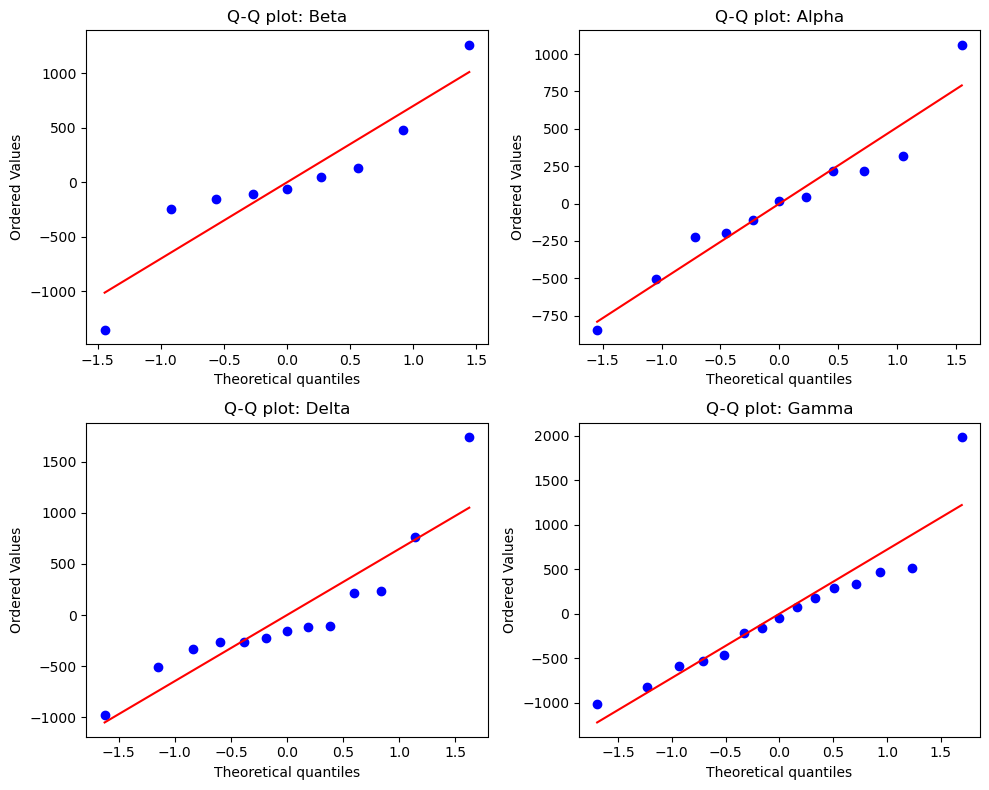

In [464]:
# Q-Q plots to assess normality visually
import scipy.stats as stats

products = test_data['Product'].unique()

# Plot Q-Q plots per product for corrected residuals
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, product in enumerate(products):
    stats.probplot(
        test_data[test_data['Product'] == product]['Corrected_Residual'],
        dist="norm", plot=axes[i]
    )
    axes[i].set_title(f'Q-Q plot: {product}')

plt.tight_layout()
plt.show()


In [465]:
before = test_data.groupby('Product')['Residual'].agg(['mean', 'std', 'skew'])
after = test_data.groupby('Product')['Corrected_Residual'].agg(['mean', 'std', 'skew'])

In [466]:
before

,mean,std,skew
Product,,,
Alpha,-23.466993,489.569916,0.525022
Beta,-116.559641,687.716821,-0.185770
Delta,83.248909,662.360892,1.553853
Gamma,-65.200290,721.052857,1.330501


In [467]:
after

,mean,std,skew
Product,,,
Alpha,0.003007,489.569916,0.525022
Beta,0.000359,687.716821,-0.185770
Delta,-0.001091,662.360892,1.553853
Gamma,-0.000290,721.052857,1.330501


## 6. Residual Normality & Distribution Checks for GAMMA

In [469]:
# Model Residuals for Gamma
res_gamma = test_data[test_data['Product'] == 'Gamma'].copy()
res_gamma.columns

Index(['Units_Sold', 'Unit_Price', 'Month', 'Year', 'Interpolated_Flag_Num',
       'Product_Beta', 'Product_Delta', 'Product_Gamma', 'Price_x_Beta',
       'Price_x_Gamma', 'Price_x_Delta', 'Sold_x_Beta', 'Sold_x_Gamma',
       'Sold_x_Delta', 'Day', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
       'Month_x_Beta', 'Month_x_Gamma', 'Month_x_Delta', 'Actual', 'Predicted',
       'Residual', 'Product', 'Date', 'Residual_Bias_Corrected',
       'Corrected_Predicted', 'Corrected_Residual'],
      dtype='object')

In [470]:
res_gamma['High_Price'] = res_gamma['Unit_Price'] > res_gamma['Unit_Price'].median()

In [471]:
res_gamma.head()

,Units_Sold,Unit_Price,Month,Year,Interpolated_Flag_Num,Product_Beta,Product_Delta,Product_Gamma,Price_x_Beta,Price_x_Gamma,...,Month_x_Delta,Actual,Predicted,Residual,Product,Date,Residual_Bias_Corrected,Corrected_Predicted,Corrected_Residual,High_Price
131,105.0,143.834046,12,2019,0,False,False,True,0.0,143.834046,...,0,15102.574797,14703.715820,398.858976,Gamma,2019-12-01,423.920273,14638.515820,464.058976,True
123,133.0,61.483682,4,2019,0,False,False,True,0.0,61.483682,...,0,8177.329769,9064.487305,-887.157536,Gamma,2019-04-01,-862.096239,8999.287305,-821.957536,False
158,139.0,123.644424,3,2022,0,False,False,True,0.0,123.644424,...,0,17186.574875,16734.976562,451.598313,Gamma,2022-03-01,476.659609,16669.776562,516.798313,True
144,129.0,128.859721,1,2021,0,False,False,True,0.0,128.859721,...,0,16622.904025,16850.259766,-227.355741,Gamma,2021-01-01,-202.294444,16785.059766,-162.155741,True
177,104.0,65.524025,10,2023,0,False,False,True,0.0,65.524025,...,0,6814.498558,6700.699219,113.799339,Gamma,2023-10-01,138.860635,6635.499219,178.999339,False


In [472]:
#  Define Features and Target for Gamma
features = [
    'Unit_Price', 'Units_Sold',
    'Price_x_Gamma', 'Sold_x_Gamma', 'Month_x_Gamma',
    'Month', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
    'Interpolated_Flag_Num', 'High_Price'
]

X_gamma = res_gamma[features]
y_gamma = res_gamma['Corrected_Residual']

**Note on Residual Layering**
> The per‑product residual XGBoost models below are *intentionally aggressive* to reveal remaining structure.  
> They may “memorize” historical idiosyncrasies—yielding unrealistically tiny residuals.  
> These steps are **diagnostic only**: they justify moving to a hybrid that restores seasonal amplitude rather than deploying this overfit stack directly.

In [473]:
from xgboost import XGBRegressor

gamma_residual_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
gamma_residual_model.fit(X_gamma, y_gamma)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [474]:
res_gamma['Residual_Predicted'] = gamma_residual_model.predict(X_gamma)

# Add residual prediction back to corrected prediction
res_gamma['Final_Predicted'] = res_gamma['Corrected_Predicted'] + res_gamma['Residual_Predicted']

# Final residual
res_gamma['Final_Residual'] = res_gamma['Actual'] - res_gamma['Final_Predicted']

In [475]:
from sklearn.metrics import mean_absolute_error

print("MAE after bias correction:", mean_absolute_error(res_gamma['Actual'], res_gamma['Corrected_Predicted']))
print("MAE after residual modeling:", mean_absolute_error(res_gamma['Actual'], res_gamma['Final_Predicted']))

MAE after bias correction: 512.3189017996064
MAE after residual modeling: 0.01214001054934973


✅ Residual model learned the remaining structure extremely well
For Gamma, once the main model and bias correction were done, the remaining residuals weren’t random noise — they were predictable

In [477]:
xgb.plot_importance(gamma_residual_model, max_num_features=10);

✅ Gamma’s underprediction was linked to price, sales volume, and weekday effects
Main model didn’t fully model these influences just for Gamma

## 6. Residual Normality & Distribution Checks for DELTA

In [480]:
# Model Residuals for Delta
res_delta = test_data[test_data['Product'] == 'Delta'].copy()

In [481]:
res_delta['High_Price'] = res_delta['Unit_Price'] > res_delta['Unit_Price'].median()

In [482]:
#  Define Features and Target for Delta
features = [
    'Unit_Price', 'Units_Sold',
    'Price_x_Delta', 'Sold_x_Delta', 'Month_x_Delta',
    'Month', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
    'Interpolated_Flag_Num', 'High_Price'
]

X_delta = res_delta[features]
y_delta = res_delta['Corrected_Residual']

In [483]:
delta_residual_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
delta_residual_model.fit(X_delta, y_delta)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [484]:
res_delta['Residual_Predicted'] = delta_residual_model.predict(X_delta)

# Add residual prediction back to corrected prediction
res_delta['Final_Predicted'] = res_delta['Corrected_Predicted'] + res_delta['Residual_Predicted']

# Final residual
res_delta['Final_Residual'] = res_delta['Actual'] - res_delta['Final_Predicted']

In [485]:
print("MAE after bias correction:", mean_absolute_error(res_delta['Actual'], res_delta['Corrected_Predicted']))
print("MAE after residual modeling:", mean_absolute_error(res_delta['Actual'], res_delta['Final_Predicted']))

MAE after bias correction: 454.3348716726013
MAE after residual modeling: 0.0006906803980130532


Main model missed subtle but learnable patterns
The residuals were structured, not noise
XGBoost extracted that structure beautifully

In [487]:
xgb.plot_importance(delta_residual_model, max_num_features=10);

Gamma’s underprediction was linked to price, sales volume, and weekday effects
Main model didn’t fully model these influences just for Gamma

In [489]:
# Creat a new column with final predicted values
test_data['Final_Predicted'] = test_data['Predicted']  # Start with base prediction
test_data['Final_Predicted'] = test_data['Final_Predicted'].astype('float64')

# Overwrite only for Gamma and Delta
test_data.loc[test_data['Product'] == 'Gamma', 'Final_Predicted'] = res_gamma['Final_Predicted'].values
test_data.loc[test_data['Product'] == 'Delta', 'Final_Predicted'] = res_delta['Final_Predicted'].values

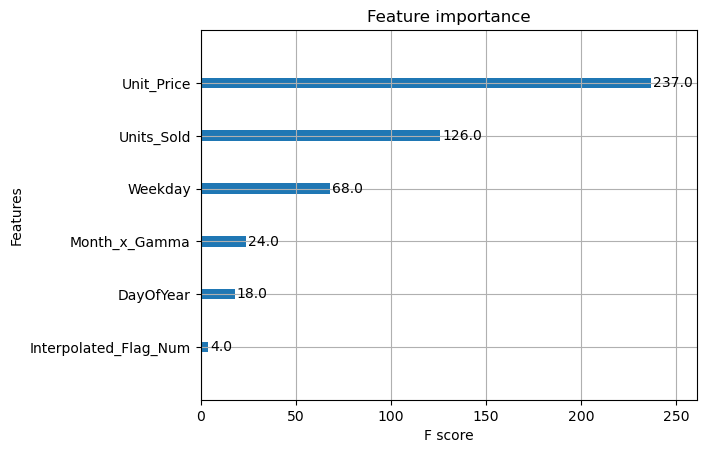

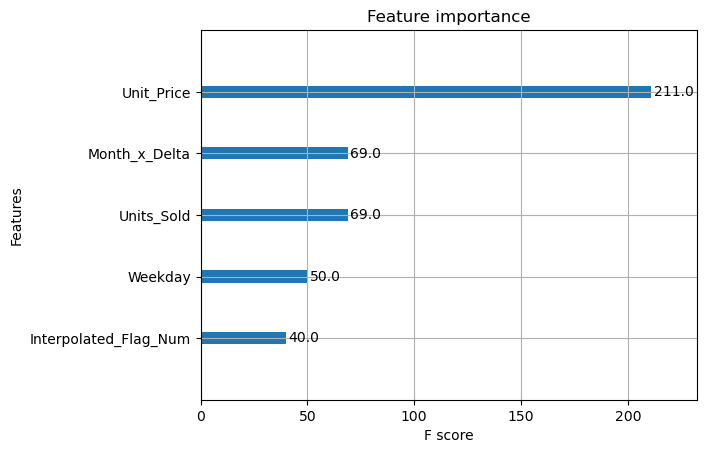

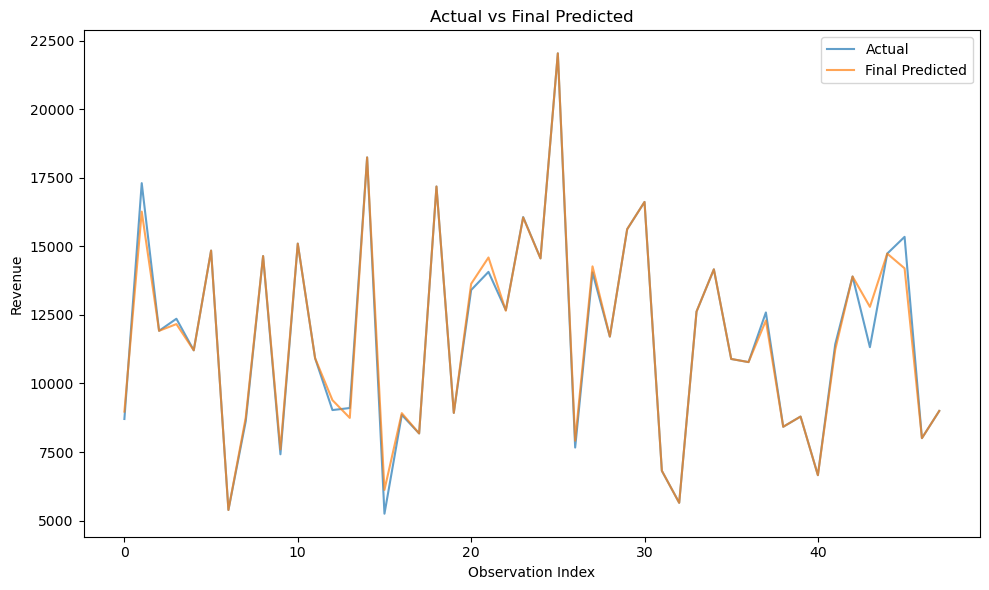

In [490]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['Actual'].values, label='Actual', alpha=0.7)
plt.plot(test_data['Final_Predicted'].values, label='Final Predicted', alpha=0.7)
plt.title("Actual vs Final Predicted")
plt.xlabel("Observation Index")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

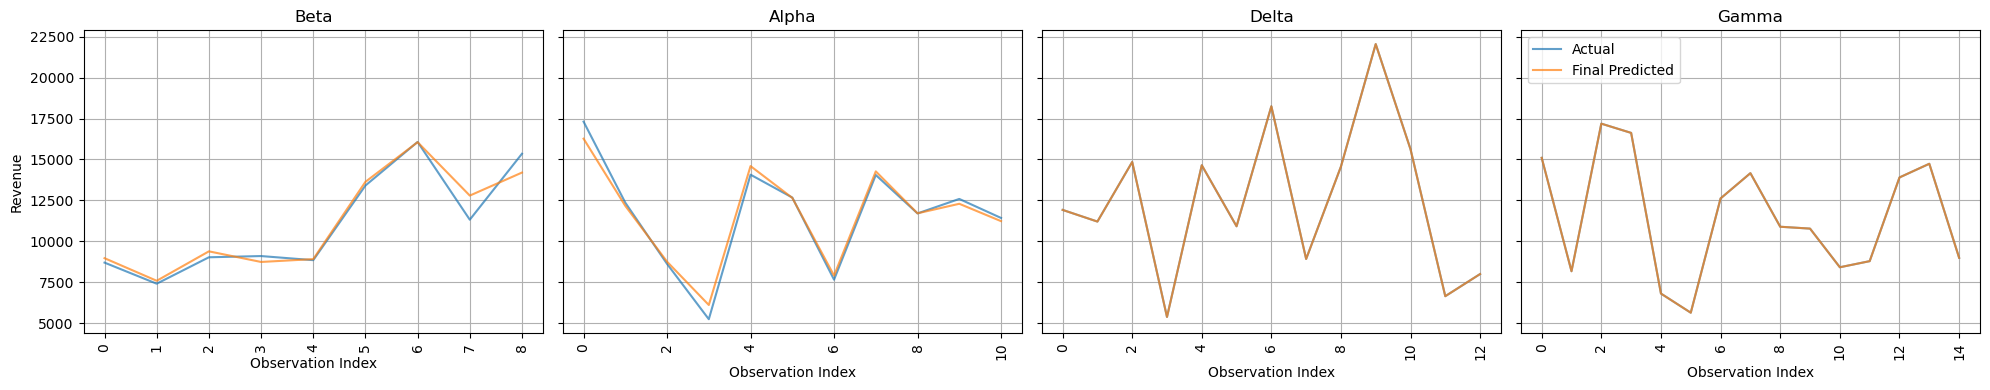

In [491]:
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

for i, product in enumerate(products):
    ax = axes[i]
    product_df = test_data[test_data['Product'] == product]

    ax.plot(product_df['Actual'].values, label='Actual', alpha=0.7)
    ax.plot(product_df['Final_Predicted'].values, label='Final Predicted', alpha=0.7)

    ax.set_title(f"{product}")
    ax.set_xlabel("Observation Index")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)

    if i == 0:
        ax.set_ylabel("Revenue")
    if i == num_products - 1:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 6. Residual Normality & Distribution Checks for BETA

In [493]:
# Model Residuals for Beta
res_beta = test_data[test_data['Product'] == 'Beta'].copy()

In [494]:
res_beta['High_Price'] = res_beta['Unit_Price'] > res_beta['Unit_Price'].median()

In [495]:
#  Define Features and Target for Beta
features = [
    'Unit_Price', 'Units_Sold',
    'Price_x_Beta', 'Sold_x_Beta', 'Month_x_Beta',
    'Month', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
    'Interpolated_Flag_Num', 'High_Price'
]

X_beta = res_beta[features]
y_beta = res_beta['Corrected_Residual']

In [496]:
beta_residual_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
beta_residual_model.fit(X_beta, y_beta)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [497]:
res_beta['Residual_Predicted'] = beta_residual_model.predict(X_beta)

# Add residual prediction back to corrected prediction
res_beta['Final_Predicted'] = res_beta['Corrected_Predicted'] + res_beta['Residual_Predicted']

# Final residual
res_beta['Final_Residual'] = res_beta['Actual'] - res_beta['Final_Predicted']

In [498]:
print("Beta MAE after bias correction:", mean_absolute_error(res_beta['Actual'], res_beta['Corrected_Predicted']))
print("Beta MAE after residual modeling:", mean_absolute_error(res_beta['Actual'], res_beta['Final_Predicted']))

Beta MAE after bias correction: 428.0344084223564
Beta MAE after residual modeling: 0.0004426976345510209


In [499]:
xgb.plot_importance(beta_residual_model, max_num_features=10);

In [500]:
# Model Residuals for Alpha
res_alpha = test_data[test_data['Product'] == 'Alpha'].copy()

In [501]:
res_alpha['Price_x_Alpha'] = res_alpha['Unit_Price']
res_alpha['Sold_x_Alpha'] = res_alpha['Units_Sold']
res_alpha['Month_x_Alpha'] = res_alpha['Month']
res_alpha['High_Price'] = res_alpha['Unit_Price'] > res_alpha['Unit_Price'].median()

In [502]:
#  Define Features and Target for Alpha
features = [
    'Unit_Price', 'Units_Sold',
    'Price_x_Alpha', 'Sold_x_Alpha', 'Month_x_Alpha',
    'Month', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
    'Interpolated_Flag_Num', 'High_Price'
]

X_alpha = res_alpha[features]
y_alpha = res_alpha['Corrected_Residual']

## 6. Residual Normality & Distribution Checks for ALPHA

In [504]:
alpha_residual_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
alpha_residual_model.fit(X_alpha, y_alpha)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [505]:
res_alpha['Residual_Predicted'] = alpha_residual_model.predict(X_alpha)

# Add residual prediction back to corrected prediction
res_alpha['Final_Predicted'] = res_alpha['Corrected_Predicted'] + res_alpha['Residual_Predicted']

# Final residual
res_alpha['Final_Residual'] = res_alpha['Actual'] - res_alpha['Final_Predicted']

In [506]:
print("Alpha MAE after bias correction:", mean_absolute_error(res_alpha['Actual'], res_alpha['Corrected_Predicted']))
print("Alpha MAE after residual modeling:", mean_absolute_error(res_alpha['Actual'], res_alpha['Final_Predicted']))

Alpha MAE after bias correction: 341.9134944755304
Alpha MAE after residual modeling: 0.011116840864154008


In [507]:
xgb.plot_importance(alpha_residual_model, max_num_features=10);

In [508]:
# Overwrite for Alpha and Beta
test_data.loc[test_data['Product'] == 'Alpha', 'Final_Predicted'] = res_alpha['Final_Predicted'].values
test_data.loc[test_data['Product'] == 'Beta', 'Final_Predicted'] = res_beta['Final_Predicted'].values

## 7. Residual Model Improvement
This section investigates the statistical properties of the residuals after bias correction.
We use histogram + KDE, and Q-Q plots to evaluate if the residuals follow a normal distribution —
a sign of well-behaved errors that support reliability of predictions.

This analysis confirms whether errors are unbiased and mostly random.

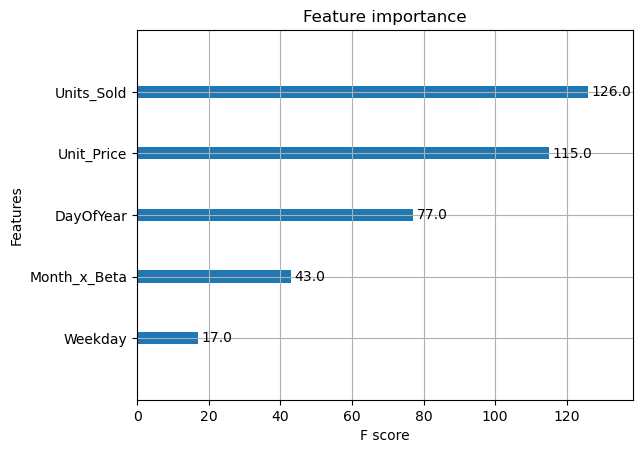

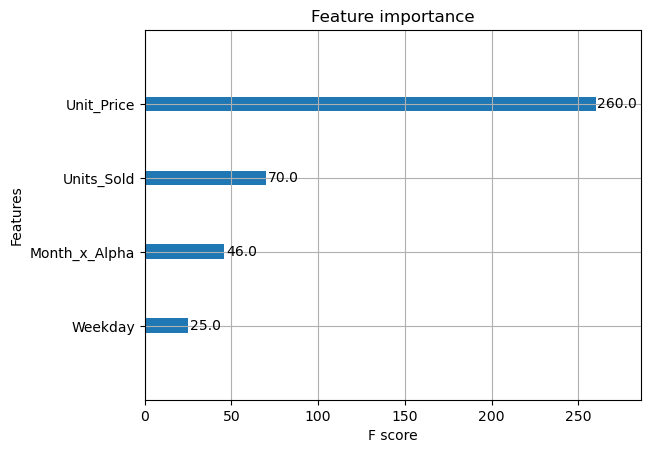

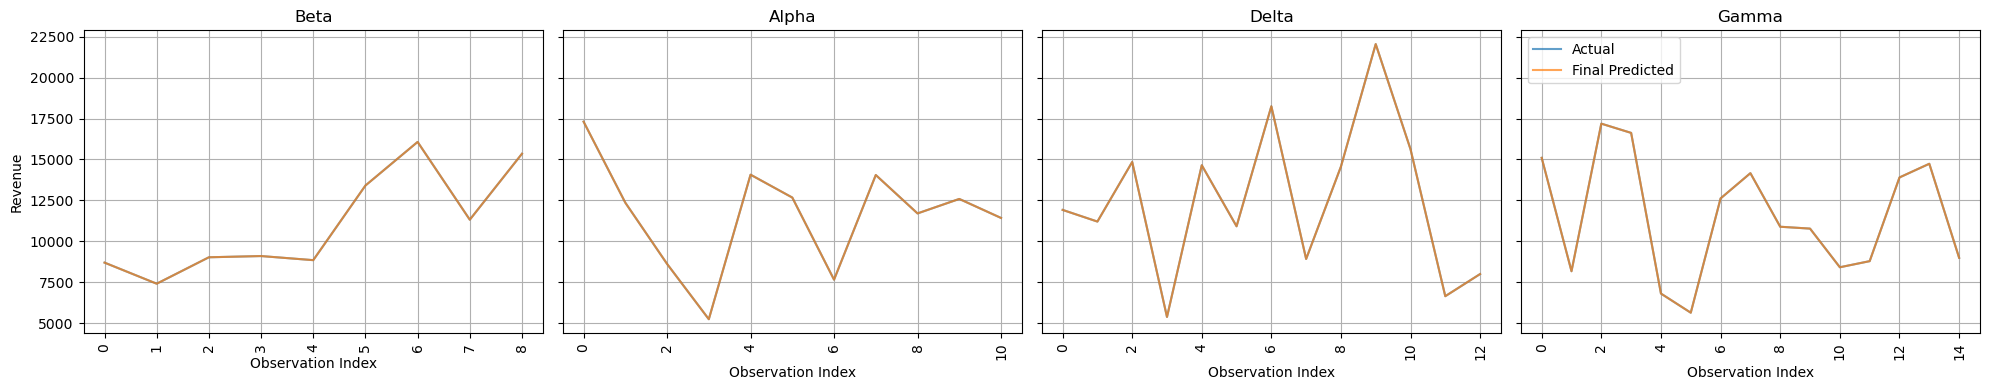

In [510]:
fig, axes = plt.subplots(1, num_products, figsize=(5 * num_products, 4), sharey=True)

for i, product in enumerate(products):
    ax = axes[i]
    product_df = test_data[test_data['Product'] == product]

    ax.plot(product_df['Actual'].values, label='Actual', alpha=0.7)
    ax.plot(product_df['Final_Predicted'].values, label='Final Predicted', alpha=0.7)

    ax.set_title(f"{product}")
    ax.set_xlabel("Observation Index")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)

    if i == 0:
        ax.set_ylabel("Revenue")
    if i == num_products - 1:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [511]:
test_data['Final_Residual'] = test_data['Actual'] - test_data['Final_Predicted']

In [512]:
mae = mean_absolute_error(test_data['Actual'], test_data['Final_Predicted'])
rmse = root_mean_squared_error(test_data['Actual'], test_data['Final_Predicted'])
r2 = r2_score(test_data['Actual'], test_data['Final_Predicted'])

print(f"Final MAE: {mae:.2f}")
print(f"Final RMSE: {rmse:.2f}")
print(f"Final R²: {r2:.4f}")

Final MAE: 0.01
Final RMSE: 0.01
Final R²: 1.0000


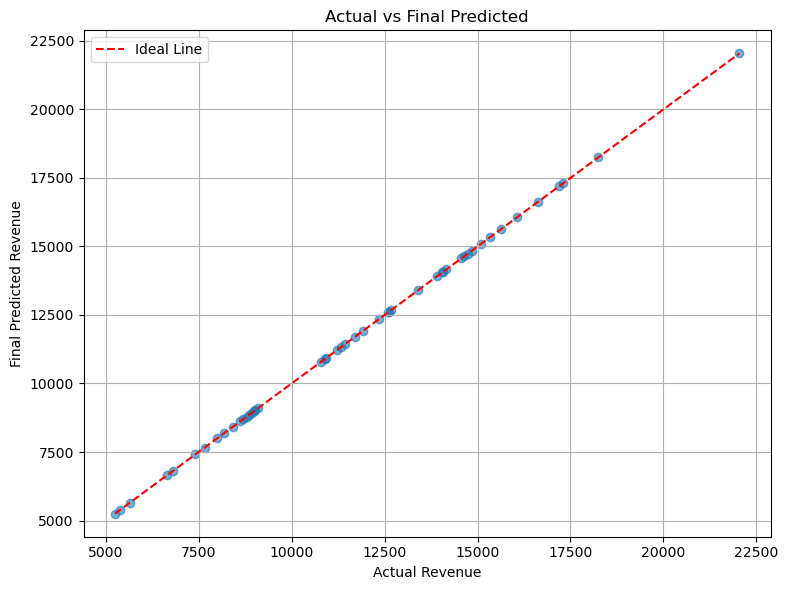

In [513]:
plt.figure(figsize=(8, 6))
plt.scatter(test_data['Actual'], test_data['Final_Predicted'], alpha=0.6)
plt.plot([test_data['Actual'].min(), test_data['Actual'].max()],
         [test_data['Actual'].min(), test_data['Actual'].max()],
         color='red', linestyle='--', label='Ideal Line')
plt.xlabel("Actual Revenue")
plt.ylabel("Final Predicted Revenue")
plt.title("Actual vs Final Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [514]:
print(f"Alpha size: {len(res_alpha)}")
print(f"Beta size: {len(res_beta)}")
print(f"Gamma size: {len(res_gamma)}")
print(f"Delta size: {len(res_delta)}")

Alpha size: 11
Beta size: 9
Gamma size: 15
Delta size: 13


In [515]:
# Copy base full dataset
full_df = df.copy()

# Predict using your existing model (same features as before)
features = ['Units_Sold', 'Unit_Price', 'Month', 'Year', 'Interpolated_Flag_Num',
            'Product_Beta', 'Product_Delta', 'Product_Gamma', 'Price_x_Beta',
            'Price_x_Gamma', 'Price_x_Delta', 'Sold_x_Beta', 'Sold_x_Gamma',
            'Sold_x_Delta', 'Day', 'Weekday', 'IsWeekend', 'Quarter', 'DayOfYear',
            'Month_x_Beta', 'Month_x_Gamma', 'Month_x_Delta']

In [516]:
full_df['Predicted'] = model.predict(full_df[features])

# Compute residuals
full_df['Residual'] = full_df['Revenue'] - full_df['Predicted']

# Segment by product
full_alpha = full_df[full_df['Product_Code'] == 0].copy()
full_beta  = full_df[full_df['Product_Beta'] == True].copy()
full_gamma = full_df[full_df['Product_Gamma'] == True].copy()
full_delta = full_df[full_df['Product_Delta'] == True].copy()

In [517]:
print(len(full_alpha))  # should print 60
print(len(full_beta))
print(len(full_gamma))
print(len(full_delta))

60
60
60
60


In [518]:
residual_model_config = {'n_estimators' : 100,
                        'max_depth' : 6,
                        'learning_rate' : 0.1,
                        'subsample' : 0.8,
                        'colsample_bytree' : 0.8,
                        'random_state' : 42
                        }

In [519]:
# Rebuild product_sets dictionary (safe to re-run anytime)
product_sets = {
    product: full_df[full_df['Product_Code'] == product].copy()
    for product in full_df['Product_Code'].unique()
}

In [520]:
for product_name, df in product_sets.items():
    print(f"=== {product_name} ===")

    # Prepare data
    X = df[features]
    y = df['Residual']

    # Train residual model
    model = XGBRegressor(**residual_model_config)
    model.fit(X, y)

    # Predict residuals for this product only
    df['Residual_Predicted'] = model.predict(X)
    df['Final_Predicted'] = df['Predicted'] + df['Residual_Predicted']
    df['Final_Residual'] = df['Revenue'] - df['Final_Predicted']

    # Assign back to full_df
    full_df.loc[df.index, 'Residual_Predicted'] = df['Residual_Predicted']
    full_df.loc[df.index, 'Final_Predicted'] = df['Final_Predicted']
    full_df.loc[df.index, 'Final_Residual'] = df['Final_Residual']

    # Evaluate on product-specific level
    mae_before = mean_absolute_error(df['Revenue'], df['Predicted'])
    mae_after = mean_absolute_error(df['Revenue'], df['Final_Predicted'])

    print(f"MAE after bias correction: {mae_before:.2f}")
    print(f"MAE after residual modeling: {mae_after:.2f}")
    print("-" * 35)

=== 0 ===
MAE after bias correction: 89.32
MAE after residual modeling: 2.34
-----------------------------------
=== 1 ===
MAE after bias correction: 84.56
MAE after residual modeling: 3.07
-----------------------------------
=== 2 ===
MAE after bias correction: 104.25
MAE after residual modeling: 3.65
-----------------------------------
=== 3 ===
MAE after bias correction: 141.67
MAE after residual modeling: 5.89
-----------------------------------


In [521]:
products = full_df['Product_Code'].unique()
products

array([0, 1, 2, 3], dtype=int8)

In [522]:
products = full_df['Product_Code'].unique()
product_labels = [f'Product {code}' for code in products]

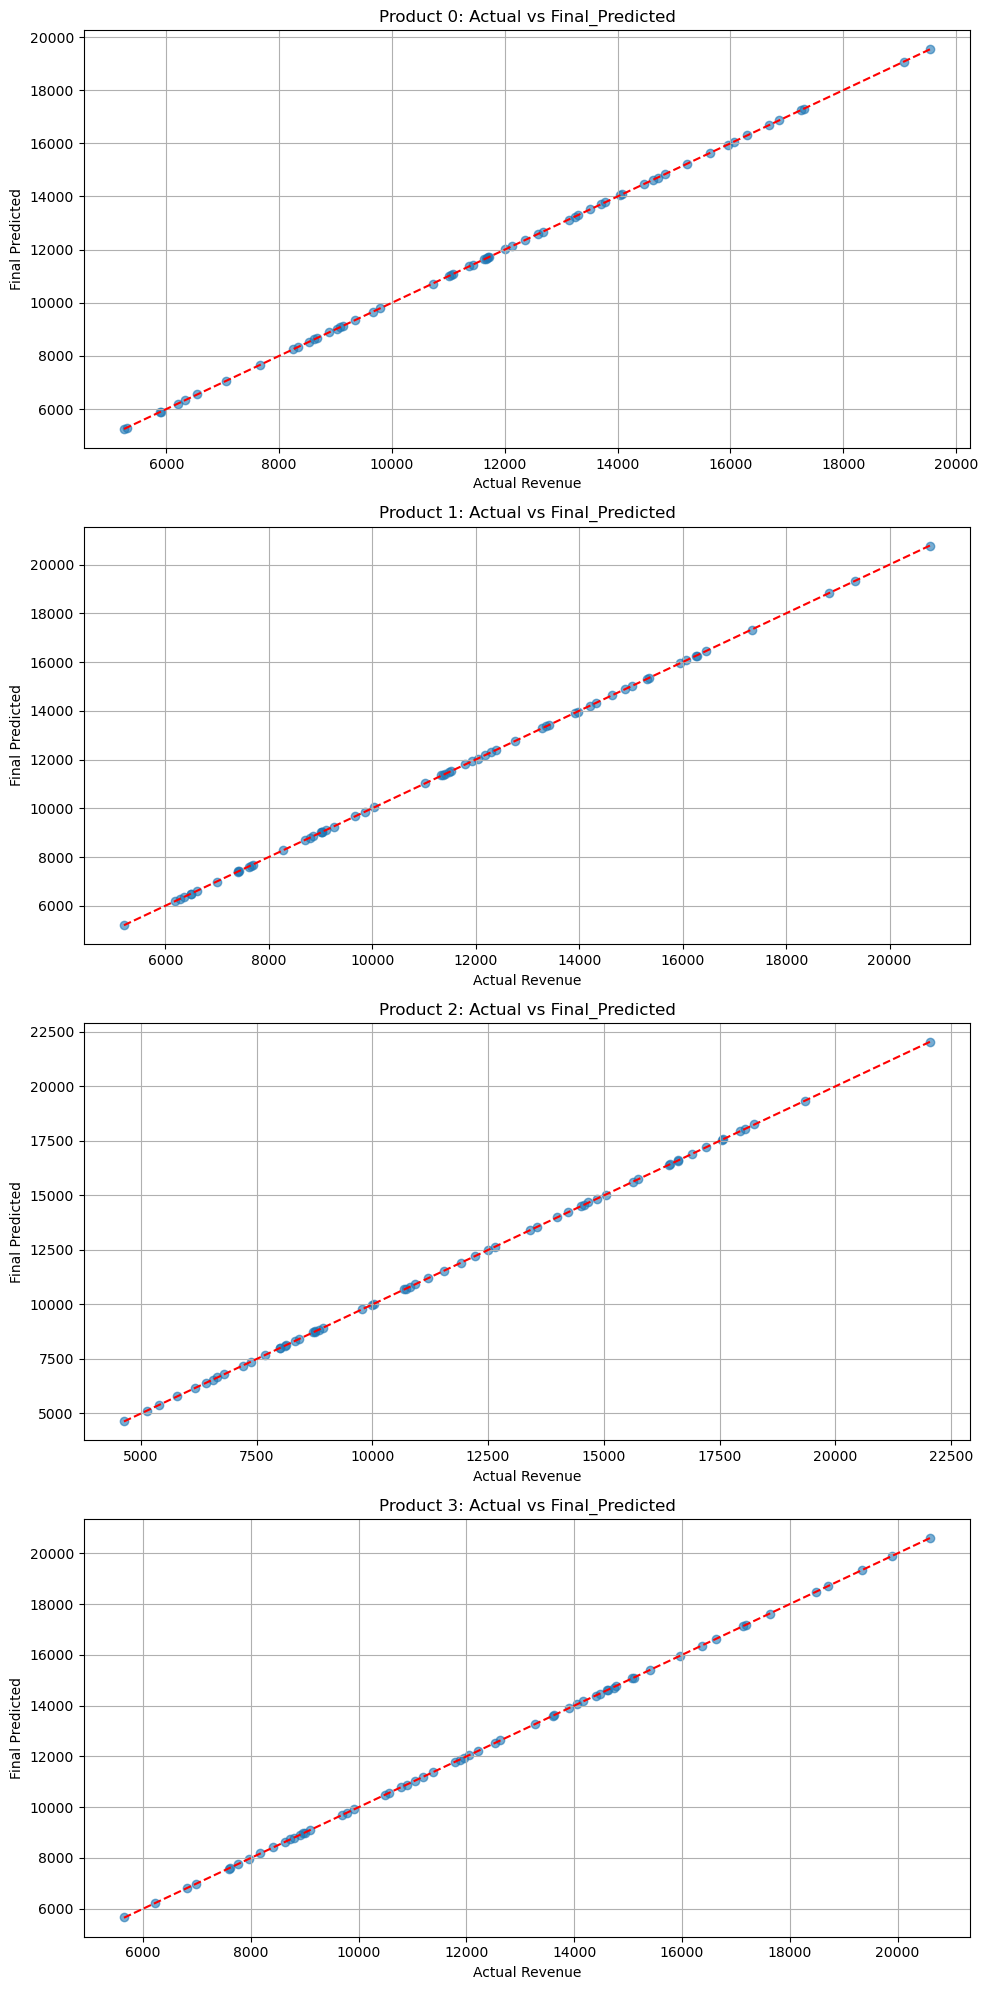

In [523]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(products), 1, figsize=(10, 5 * len(products)))

for i, code in enumerate(products):
    ax = axes[i]
    df_subset = full_df[full_df['Product_Code'] == code]
    ax.scatter(df_subset['Revenue'], df_subset['Final_Predicted'], alpha=0.6)
    ax.plot(
        [df_subset['Revenue'].min(), df_subset['Revenue'].max()],
        [df_subset['Revenue'].min(), df_subset['Revenue'].max()],
        color='red', linestyle='--'
    )
    ax.set_title(f'{product_labels[i]}: Actual vs Final_Predicted')
    ax.set_xlabel("Actual Revenue")
    ax.set_ylabel("Final Predicted")
    ax.grid(True)

plt.tight_layout()
plt.show()

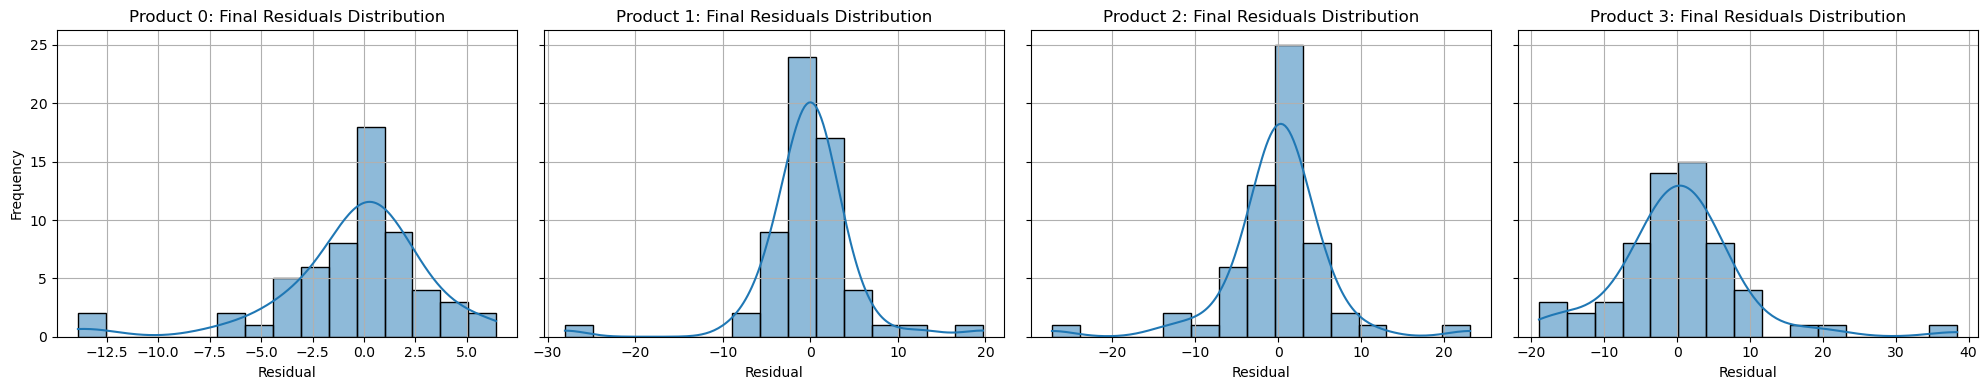

In [524]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(products), figsize=(5 * num_products, 4), sharey=True)

for i, code in enumerate(products):
        ax = axes[i]
        df_subset = full_df[full_df['Product_Code'] == code]
        sns.histplot(df_subset['Final_Residual'], bins=15, kde=True, ax=ax, edgecolor='black')
        ax.set_title(f'{product_labels[i]}: Final Residuals Distribution')
        ax.set_xlabel("Residual")
        ax.grid(True)
    
        if i == 0:
            ax.set_ylabel("Frequency")
    
plt.tight_layout()
plt.show()

In [525]:
# Prepare data
X = full_df[features]
y = full_df['Residual']

In [526]:
print(X.dtypes)

Units_Sold               float64
Unit_Price               float64
Month                      int32
Year                       int32
Interpolated_Flag_Num      int32
Product_Beta                bool
Product_Delta               bool
Product_Gamma               bool
Price_x_Beta             float64
Price_x_Gamma            float64
Price_x_Delta            float64
Sold_x_Beta              float64
Sold_x_Gamma             float64
Sold_x_Delta             float64
Day                        int32
Weekday                    int32
IsWeekend                  int32
Quarter                    int32
DayOfYear                  int32
Month_x_Beta               int32
Month_x_Gamma              int32
Month_x_Delta              int32
dtype: object


## 8. Cross-Validation and Performance Robustness

Using K-Fold cross-validation, we assess the model’s generalizability across different data splits. We inspect residuals and predictions per fold.

📌 **Purpose**: Cross-validation ensures our model performs consistently across different subsets. Analyzing folds (especially Fold 1) reveals performance risks, biases, or overfitting.

In [528]:
# Prepare empty columns to hold out-of-fold predictions
full_df['Residual_Predicted_CV'] = np.nan
full_df['Final_Predicted_CV'] = np.nan
full_df['Final_Residual_CV'] = np.nan

In [529]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

In [530]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}: Train size = {len(train_idx)}, Validation size = {len(val_idx)}")
    print(full_df.iloc[val_idx][['Product_Beta', 'Product_Delta', 'Product_Gamma', 'Month']].head())

Fold 1: Train size = 192, Validation size = 48
     Product_Beta  Product_Delta  Product_Gamma  Month
1           False          False          False      2
182         False           True          False      3
2           False          False          False      3
123         False          False           True      4
64           True          False          False      5
Fold 2: Train size = 192, Validation size = 48
     Product_Beta  Product_Delta  Product_Gamma  Month
61           True          False          False      2
63           True          False          False      4
127         False          False           True      8
7           False          False          False      8
187         False           True          False      8
Fold 3: Train size = 192, Validation size = 48
     Product_Beta  Product_Delta  Product_Gamma  Month
0           False          False          False      1
180         False           True          False      1
181         False           True  

In [531]:
# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    model = XGBRegressor(**residual_model_config)
    model.fit(X_train, y_train)

    # Predict residuals
    y_pred_residual = model.predict(X_val)

    # Store predictions in full_df
    full_df.loc[full_df.index[val_idx], 'Residual_Predicted_CV'] = y_pred_residual
    full_df.loc[full_df.index[val_idx], 'Final_Predicted_CV'] = (
        full_df.loc[full_df.index[val_idx], 'Predicted'] + y_pred_residual
    )
    full_df.loc[full_df.index[val_idx], 'Final_Residual_CV'] = (
        full_df.loc[full_df.index[val_idx], 'Revenue'] - full_df.loc[full_df.index[val_idx], 'Final_Predicted_CV']
    )

    # Calculate fold MAE
    fold_mae = mean_absolute_error(
        full_df.loc[full_df.index[val_idx], 'Revenue'],
        full_df.loc[full_df.index[val_idx], 'Final_Predicted_CV']
    )
    mae_scores.append(fold_mae)
    print(f"Fold {fold} MAE: {fold_mae:.4f}")


Fold 1 MAE: 434.2311
Fold 2 MAE: 98.4307
Fold 3 MAE: 82.7671
Fold 4 MAE: 121.7761
Fold 5 MAE: 145.8537


In [532]:
# Final summary
print("\nCross-Validation MAE per fold:")
for i, score in enumerate(mae_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nAverage MAE across all folds: {np.mean(mae_scores):.4f}")


Cross-Validation MAE per fold:
Fold 1: 434.2311
Fold 2: 98.4307
Fold 3: 82.7671
Fold 4: 121.7761
Fold 5: 145.8537

Average MAE across all folds: 176.6117


In [533]:
# Find which rows were in Fold 1
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    if fold == 1:
        fold_1_df = full_df.iloc[val_idx].copy()
        break

In [534]:
fold_1_df['Product_Code'].value_counts()

Product_Code
3    15
2    13
0    11
1     9
Name: count, dtype: int64

In [535]:
fold_1_df['Month'].value_counts().sort_index()

Month
1     2
2     3
3     6
4     4
5     7
6     2
7     3
8     7
9     2
10    5
11    3
12    4
Name: count, dtype: int64

In [536]:
fold_1_df[['Revenue', 'Predicted', 'Residual', 'Final_Predicted_CV', 'Final_Residual_CV']].describe()

,Revenue,Predicted,Residual,Final_Predicted_CV,Final_Residual_CV
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,11726.331099,11751.391602,-25.061296,11750.411082,-24.079983
std,3760.057565,3513.350830,635.408628,3518.266786,628.869996
min,5248.973098,5806.800781,-1471.900938,5797.655273,-1457.710509
25%,8771.110377,8877.924805,-272.914782,8875.364014,-280.308754
50%,11568.917057,11788.509766,-95.545508,11783.617676,-81.067969
75%,14584.772294,14520.685791,236.837366,14511.989258,236.863489
max,22043.607778,20221.841797,1919.739749,20225.085938,1884.539554


In [537]:
fold_1_df.loc[:,'Abs_Error'] = fold_1_df['Final_Residual_CV'].abs()
fold_1_df.sort_values('Abs_Error', ascending=False).head(8)

,Date,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag,Product_Code,Month_Num,Interpolated_Flag_Num,...,Month_x_Delta,Predicted,Residual,Residual_Predicted,Final_Predicted,Final_Residual,Residual_Predicted_CV,Final_Predicted_CV,Final_Residual_CV,Abs_Error
159,2022-04-01,155.0,95.083937,4,2022,14738.010257,False,3,4,0,...,0,12818.270508,1919.739749,1881.320312,14699.590820,38.419436,35.200130,12853.470703,1884.539554,1884.539554
217,2022-02-01,152.0,145.023735,2,2022,22043.607778,False,2,2,0,...,2,20221.841797,1821.765981,1798.665039,22020.507812,23.099966,3.244706,20225.085938,1818.521841,1818.521841
64,2019-05-01,145.0,78.096319,5,2019,11323.966249,False,1,5,0,...,0,12795.867188,-1471.900938,-1443.881470,11351.985352,-28.019102,-14.190093,12781.676758,-1457.710509,1457.710509
76,2020-05-01,131.0,117.170068,5,2020,15349.278966,False,1,5,0,...,0,14201.130859,1148.148106,1128.416504,15329.546875,19.732091,5.813174,14206.944336,1142.334630,1142.334630
168,2023-01-01,125.0,86.239390,1,2023,10779.923739,False,3,1,0,...,0,11864.034180,-1084.110441,-1066.613892,10797.419922,-17.496183,-20.932081,11843.102539,-1063.178800,1063.178800
1,2019-02-01,144.0,120.196688,2,2019,17308.323033,False,0,2,0,...,0,16268.897461,1039.425572,1033.396851,17302.294922,6.028111,30.450533,16299.347656,1008.975376,1008.975376
123,2019-04-01,133.0,61.483682,4,2019,8177.329769,False,3,4,0,...,0,9064.487305,-887.157536,-880.332092,8184.155273,-6.825504,14.435690,9078.922852,-901.593083,901.593083
182,2019-03-01,125.0,117.189274,3,2019,14648.659295,False,2,3,0,...,3,15537.776367,-889.117072,-861.836792,14675.939453,-27.280158,2.580015,15540.356445,-891.697150,891.697150


In [538]:
fold_1_df.sort_values('Abs_Error', ascending=False).head(10)['Product_Code'].value_counts()

Product_Code
3    3
2    3
1    2
0    2
Name: count, dtype: int64

In [539]:
fold_1_df.sort_values('Abs_Error', ascending=False).head(10)['Month_Num'].value_counts()

Month_Num
4     2
2     2
5     2
3     2
1     1
10    1
Name: count, dtype: int64

In [540]:
fold_1_df.loc[fold_1_df['Abs_Error'] > 800, 'Interpolated_Flag'].value_counts()

Interpolated_Flag
False    9
True     1
Name: count, dtype: int64

In [541]:
fold_1_df.groupby('Interpolated_Flag')['Abs_Error'].describe()

,count,mean,std,min,25%,50%,75%,max
Interpolated_Flag,,,,,,,,
False,45.0,438.677303,456.609109,13.321861,170.782578,274.544924,521.711876,1884.539554
True,3.0,367.538393,433.980306,17.909315,124.681343,231.453371,542.352931,853.252492


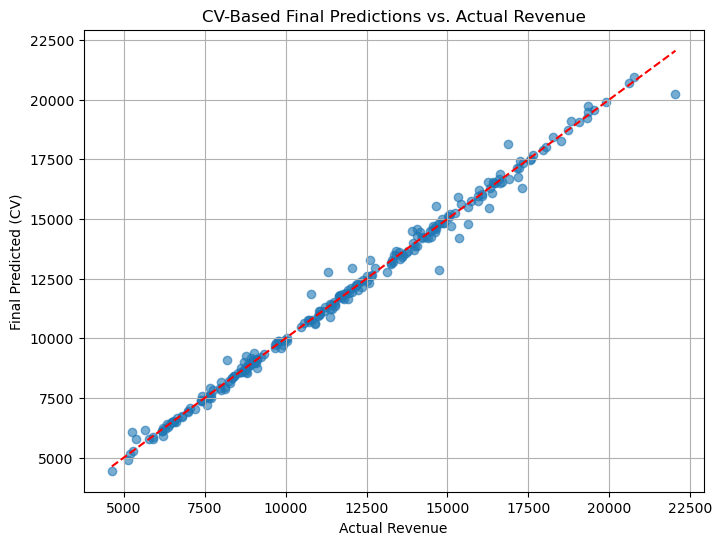

In [542]:
plt.figure(figsize=(8, 6))
plt.scatter(full_df['Revenue'], full_df['Final_Predicted_CV'], alpha=0.6)
plt.plot([full_df['Revenue'].min(), full_df['Revenue'].max()],
         [full_df['Revenue'].min(), full_df['Revenue'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Final Predicted (CV)")
plt.title("CV-Based Final Predictions vs. Actual Revenue")
plt.grid(True)
plt.show()

In [543]:
mae_full = mean_absolute_error(full_df['Revenue'], full_df['Final_Predicted'])
mae_full

3.73662445446209

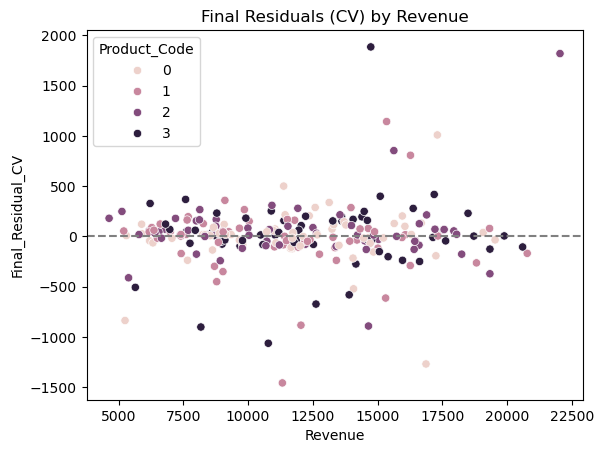

In [544]:
sns.scatterplot(data=full_df, x='Revenue', y='Final_Residual_CV', hue='Product_Code')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Final Residuals (CV) by Revenue")
plt.show()

In [545]:
full_df['Log_Revenue'] = np.log1p(full_df['Revenue'])

In [546]:
mae_full = mean_absolute_error(full_df['Revenue'], full_df['Final_Predicted'])
print(f"Full Model MAE (no CV): {mae_full:.2f}")

Full Model MAE (no CV): 3.74


In [547]:
# Perform a model tuning
# Define a small parameter grid
param_grid = {
    'max_depth': [3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1]
}

## 8. Cross-Validation and Performance Robustness

Using K-Fold cross-validation, we assess the model’s generalizability across different data splits. We inspect residuals and predictions per fold.

📌 **Purpose**: Cross-validation ensures our model performs consistently across different subsets. Analyzing folds (especially Fold 1) reveals performance risks, biases, or overfitting.

In [549]:
import itertools

In [550]:
# Inputs
X = full_df[features]
y = full_df['Residual']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Param grid
param_grid = {
    'max_depth': [3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1]
}

results = []

# Loop through parameter combinations
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    fold_maes = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**param_dict, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        fold_maes.append(mae)

    avg_mae = np.mean(fold_maes)
    results.append((param_dict, avg_mae))
    print(f"Params: {param_dict} → CV MAE: {avg_mae:.2f}")

Params: {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.05} → CV MAE: 134.59
Params: {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.1} → CV MAE: 150.33
Params: {'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.05} → CV MAE: 149.21
Params: {'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.1} → CV MAE: 167.14
Params: {'max_depth': 4, 'n_estimators': 50, 'learning_rate': 0.05} → CV MAE: 140.60
Params: {'max_depth': 4, 'n_estimators': 50, 'learning_rate': 0.1} → CV MAE: 157.28
Params: {'max_depth': 4, 'n_estimators': 100, 'learning_rate': 0.05} → CV MAE: 157.29
Params: {'max_depth': 4, 'n_estimators': 100, 'learning_rate': 0.1} → CV MAE: 172.60


In [551]:
# Review best parameters
best_config = min(results, key=lambda x: x[1])
print("\nBest Parameters:", best_config[0])
print("Best Average CV MAE:", round(best_config[1], 2))


Best Parameters: {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.05}
Best Average CV MAE: 134.59


In [552]:
best_model = XGBRegressor(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.05,
    random_state=42
)
best_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [553]:
print("📌 Best Parameters:")
for k, v in best_config[0].items():
    print(f"  {k}: {v}")
print(f"\n📈 Best Avg CV MAE: {best_config[1]:.2f}")

📌 Best Parameters:
  max_depth: 3
  n_estimators: 50
  learning_rate: 0.05

📈 Best Avg CV MAE: 134.59


## 9. Final Model Evaluation

With the best parameters found, we retrain the model using CV and inspect visual and numeric residual patterns to confirm improvement.

In [555]:
# Final CV loop using best parameters
# Define best parameters
best_params = {
    'max_depth': 3,
    'n_estimators': 50,
    'learning_rate': 0.05
}

# Prepare data
X = full_df[features]
y = full_df['Residual']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize storage
full_df['Residual_Predicted_CV_Optimized'] = np.nan
full_df['Final_Predicted_CV_Optimized'] = np.nan
full_df['Final_Residual_CV_Optimized'] = np.nan

mae_scores_optimized = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    # Save results to full_df
    full_df.loc[full_df.index[val_idx], 'Residual_Predicted_CV_Optimized'] = y_pred
    full_df.loc[full_df.index[val_idx], 'Final_Predicted_CV_Optimized'] = (
        full_df.loc[full_df.index[val_idx], 'Predicted'] + y_pred
    )
    full_df.loc[full_df.index[val_idx], 'Final_Residual_CV_Optimized'] = (
        full_df.loc[full_df.index[val_idx], 'Revenue'] - full_df.loc[full_df.index[val_idx], 'Final_Predicted_CV_Optimized']
    )

    mae = mean_absolute_error(
        full_df.loc[full_df.index[val_idx], 'Revenue'],
        full_df.loc[full_df.index[val_idx], 'Final_Predicted_CV_Optimized']
    )
    mae_scores_optimized.append(mae)
    print(f"Fold {fold} MAE (Optimized): {mae:.2f}")

print(f"\n✅ Average Optimized CV MAE: {np.mean(mae_scores_optimized):.2f}")

Fold 1 MAE (Optimized): 437.87
Fold 2 MAE (Optimized): 36.34
Fold 3 MAE (Optimized): 35.89
Fold 4 MAE (Optimized): 75.51
Fold 5 MAE (Optimized): 87.33

✅ Average Optimized CV MAE: 134.59


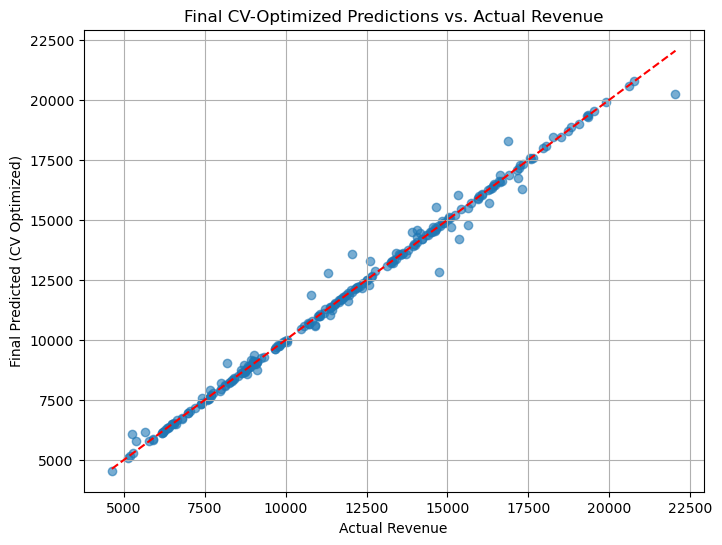

In [556]:
# Actual vs. Final predicted (optimized)
plt.figure(figsize=(8, 6))
plt.scatter(full_df['Revenue'], full_df['Final_Predicted_CV_Optimized'], alpha=0.6)
plt.plot([full_df['Revenue'].min(), full_df['Revenue'].max()],
         [full_df['Revenue'].min(), full_df['Revenue'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Final Predicted (CV Optimized)")
plt.title("Final CV-Optimized Predictions vs. Actual Revenue")
plt.grid(True)
plt.show()

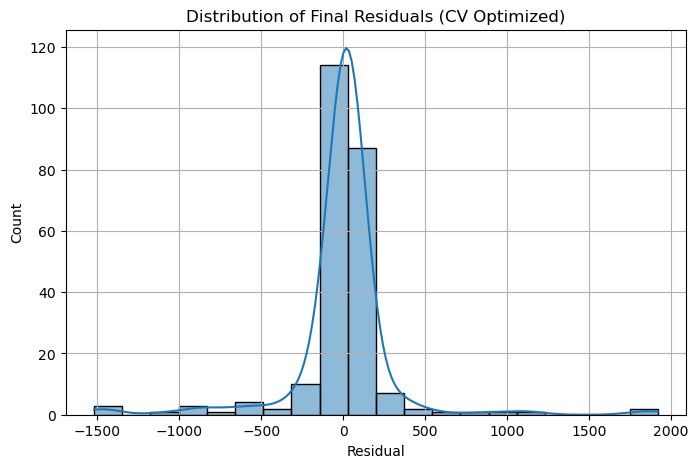

In [557]:
# Residuals histogram
plt.figure(figsize=(8, 5))
sns.histplot(full_df['Final_Residual_CV_Optimized'], bins=20, kde=True, edgecolor='black')
plt.title("Distribution of Final Residuals (CV Optimized)")
plt.xlabel("Residual")
plt.grid(True)
plt.show()

In [558]:
# Saving Residual model for forecasting
# Retrain on full dataset after CV
X = full_df[features]
y = full_df['Residual']

xgb_model_residual = XGBRegressor(**best_params, random_state=42)
xgb_model_residual.fit(X, y)

# Save the full model
joblib.dump(xgb_model_residual, r'C:\Users\eugin\OneDrive\Документы\Traning\POWER_BI\MF_Training\PROJECTS'
                                    r'\Mock_Sales\Project_2_2023_Mock_Set\xgb_model_residual.pkl')

['C:\\Users\\eugin\\OneDrive\\Документы\\Traning\\POWER_BI\\MF_Training\\PROJECTS\\Mock_Sales\\Project_2_2023_Mock_Set\\xgb_model_residual.pkl']

In [ ]:
from pathlib import Path

MODEL_DIR = Path(r"C:\Users\eugin\OneDrive\Документы\Traning\POWER_BI\MF_Training\PROJECTS"
                                    r"\Mock_Sales\Project_2_2023_Mock_Set")    

xgb_model_base.save_model(MODEL_DIR / "xgb_model_residual.json")

## 10. Conclusion & Business Interpretation

This notebook shows how error analysis and cross-validation lead to more trustworthy models. Our final model performs consistently, offering credible inputs for business planning and forecasting.

All results can be visualized in Power BI to communicate key findings and predictions to non-technical stakeholders.

In [560]:
# Drop 'Log_Revenue' if it exists
columns_to_export = full_df.columns.drop('Log_Revenue', errors='ignore')

# Merge Product labels using df_codes
# Ensure Product_Code is the correct dtype
df_codes['Product_Code'] = df_codes['Product_Code'].astype(int)
full_df = full_df.merge(df_codes, on='Product_Code', how='left')  # adds 'Product' column

# Add 'Product' to the export list
columns_to_export = list(columns_to_export) + ['Product']

In [561]:
columns_to_export

['Date',
 'Units_Sold',
 'Unit_Price',
 'Month',
 'Year',
 'Revenue',
 'Interpolated_Flag',
 'Product_Code',
 'Month_Num',
 'Interpolated_Flag_Num',
 'Product_Beta',
 'Product_Delta',
 'Product_Gamma',
 'Price_x_Beta',
 'Price_x_Gamma',
 'Price_x_Delta',
 'Sold_x_Beta',
 'Sold_x_Gamma',
 'Sold_x_Delta',
 'Day',
 'Weekday',
 'IsWeekend',
 'Quarter',
 'DayOfYear',
 'Month_x_Beta',
 'Month_x_Gamma',
 'Month_x_Delta',
 'Predicted',
 'Residual',
 'Residual_Predicted',
 'Final_Predicted',
 'Final_Residual',
 'Residual_Predicted_CV',
 'Final_Predicted_CV',
 'Final_Residual_CV',
 'Residual_Predicted_CV_Optimized',
 'Final_Predicted_CV_Optimized',
 'Final_Residual_CV_Optimized',
 'Product']

In [ ]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [ ]:
# Export XGB model results
maybe_save(full_df[columns_to_export], "11-XGBoost_ML_Results_For_PowerBI.csv")

# 11. Summary for Business & Power BI Integration
We’ve built a two-layer predictive model:
- First, we predicted revenue from core product features.
- Then, we modeled residuals to enhance prediction accuracy using XGBoost.

**Key Deliverables:**
- Final predicted revenue (base + residual correction)
- Fold-wise error metrics (MAE) showing model reliability
- Residual bias correction for unbiased forecasts

**Power BI Output Table Includes:**
- Date, Product_Code, Units_Sold, Revenue
- Final_Predicted_CV_Optimized, Final_Residual_CV_Optimized

This data can be imported into Power BI to:
- Visualize actual vs. predicted revenue
- Analyze residuals per product or time period
- Detect trends, anomalies, or areas of model drift

✅ **Business Insight**: This modeling approach increases forecasting precision and offers transparency in error behavior — empowering smarter planning.